# 1. Import libraries and dataset

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Dummy input generator
import numpy as np
X = np.random.rand(32, 128, 128, 3)
y = tf.keras.utils.to_categorical(np.random.randint(0, 9, size=(32,)), num_classes=9)

# Simple model
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    Flatten(),
    Dense(9, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1250 - loss: 2.1703


In [1]:
#!pip install -q medmnist
!pip install -q xgboost scikit-learn matplotlib seaborn opencv-python albumentations scikit-image mahotas scipy imbalanced-learn umap-learn pillow tqdm #tensorflow
!mkdir class_task

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 25.0 MB/s eta 0:00:00


In [2]:
#import medmnist
#from medmnist import INFO, Evaluator, PathMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import imagesize
from collections import defaultdict
import hashlib
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from collections import Counter
import shutil
import csv
from PIL import Image

In [ ]:
!python -m medmnist save --flag=pathmnist --folder=/content/class_task/ --postfix=png --download=True --size=128

In [3]:
import pprint
pathmnist_info = INFO['pathmnist']
pprint.pprint(pathmnist_info)

{'MD5': 'a8b06965200029087d5bd730944a56c1',
 'MD5_128': 'ac42d08fb904d92c244187169d1fd1d9',
 'MD5_224': '2c51a510bcdc9cf8ddb2af93af1eadec',
 'MD5_64': '55aa9c1e0525abe5a6b9d8343a507616',
 'description': 'The PathMNIST is based on a prior study for predicting '
                'survival from colorectal cancer histology slides, providing a '
                'dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image '
                'patches from hematoxylin & eosin stained histological images, '
                'and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches '
                'from a different clinical center. The dataset is comprised of '
                '9 types of tissues, resulting in a multi-class classification '
                'task. We resize the source images of 3×224×224 into 3×28×28, '
                'and split NCT-CRC-HE-100K into training and validation set '
                'with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test '
                'set.

In [3]:
# I will use my Google Drive as a persistent cache
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Upload the dataset to the drive
import tarfile
with tarfile.open('/content/class_task.tar.gz', 'w:gz') as tar:
    tar.add('/content/class_task', arcname='class_task')

!mv /content/class_task.tar.gz /content/drive/MyDrive/aml_project/

In [4]:
# Import the dataset from the drive
!cp /content/drive/MyDrive/aml_project/class_task.tar.gz /content/
!tar -xzf /content/class_task.tar.gz -C /content/ && rm /content/class_task.tar.gz

# 2. Loading and processing data


Class distribution in the full dataset:
adipose                  : 11745 samples
background               : 11413 samples
debris                   : 11851 samples
lymphocytes              : 12191 samples
mucus                    : 9931 samples
muscle                   : 14128 samples
mucosa                   : 9504 samples
cas                      : 10867 samples
adenocarcinoma           : 15550 samples


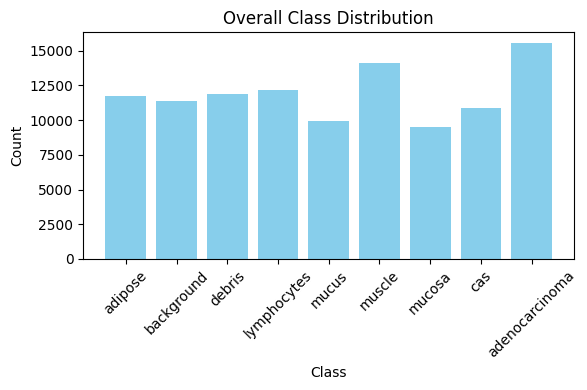


Class distribution in train set:
adipose                  : 9366 samples
background               : 9509 samples
debris                   : 10360 samples
lymphocytes              : 10401 samples
mucus                    : 8006 samples
muscle                   : 12182 samples
mucosa                   : 7886 samples
cas                      : 9401 samples
adenocarcinoma           : 12885 samples


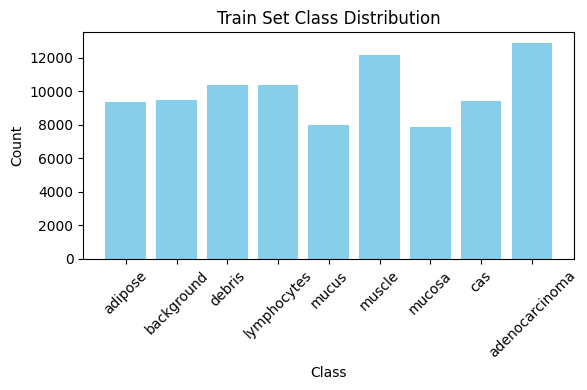


Class distribution in test set:
adipose                  : 1338 samples
background               : 847 samples
debris                   : 339 samples
lymphocytes              : 634 samples
mucus                    : 1035 samples
muscle                   : 592 samples
mucosa                   : 741 samples
cas                      : 421 samples
adenocarcinoma           : 1233 samples


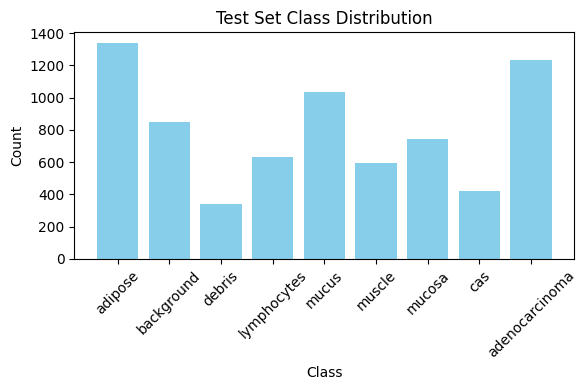


Class distribution in validation set:
adipose                  : 1041 samples
background               : 1057 samples
debris                   : 1152 samples
lymphocytes              : 1156 samples
mucus                    : 890 samples
muscle                   : 1354 samples
mucosa                   : 877 samples
cas                      : 1045 samples
adenocarcinoma           : 1432 samples


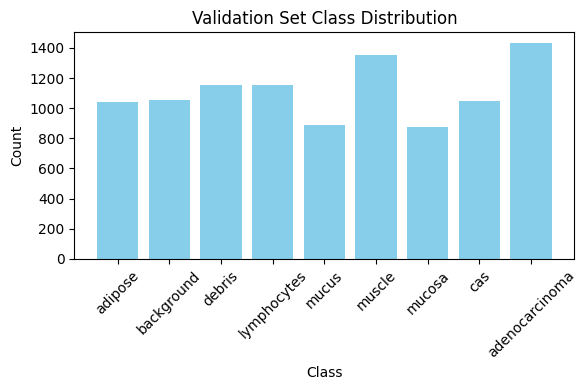

In [5]:
raw_image_metadata = pd.read_csv('/content/class_task/pathmnist_128.csv', header=None, names=['set', 'filename', 'class'])

class_names = {
    0: "adipose",
    1: "background",
    2: "debris",
    3: "lymphocytes",
    4: "mucus",
    5: "muscle", # smooth muscle
    6: "mucosa", # normal colon mucosa
    7: "cas", # cancer-associated stroma
    8: "adenocarcinoma" # colorectal adenocarcinoma epithelium
}

def compute_class_distribution(dataframe):
    return dict(Counter(dataframe['class']))

def print_distribution(dist_dict, title):
    print(f"\n{title}:")
    for class_idx in sorted(class_names):
        count = dist_dict.get(class_idx, 0)
        print(f"{class_names[class_idx]:25}: {count} samples")

def plot_distribution(dist_dict, title):
    classes = sorted(class_names.keys())
    counts = [dist_dict.get(c, 0) for c in classes]
    labels = [class_names[c] for c in classes]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, counts, color='skyblue')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

overall_dist = compute_class_distribution(raw_image_metadata)
print_distribution(overall_dist, "Class distribution in the full dataset")
plot_distribution(overall_dist, "Overall Class Distribution")

train_dist = compute_class_distribution(raw_image_metadata[raw_image_metadata['set'] == 'TRAIN'])
print_distribution(train_dist, "Class distribution in train set")
plot_distribution(train_dist, "Train Set Class Distribution")

test_dist = compute_class_distribution(raw_image_metadata[raw_image_metadata['set'] == 'TEST'])
print_distribution(test_dist, "Class distribution in test set")
plot_distribution(test_dist, "Test Set Class Distribution")

val_dist = compute_class_distribution(raw_image_metadata[raw_image_metadata['set'] == 'VALIDATION'])
print_distribution(val_dist, "Class distribution in validation set")
plot_distribution(val_dist, "Validation Set Class Distribution")

In [6]:
%cd /content/class_task
raw_image_metadata.to_csv('raw_image_metadata.csv', index=False)

/content/class_task


This next script computes the MD5 hash of every single image file in the dataset to check for duplicates. This cleanup process is not needed for the PathMNIST dataset, as it is already preprocessed and curated. However, this duplicate check could be useful for other datasets.

100%|██████████| 107180/107180 [01:49<00:00, 975.06it/s]



Duplicate Analysis:
Total duplicate images found: 0
No duplicates found.

File extension counts:
.png: 107180 images


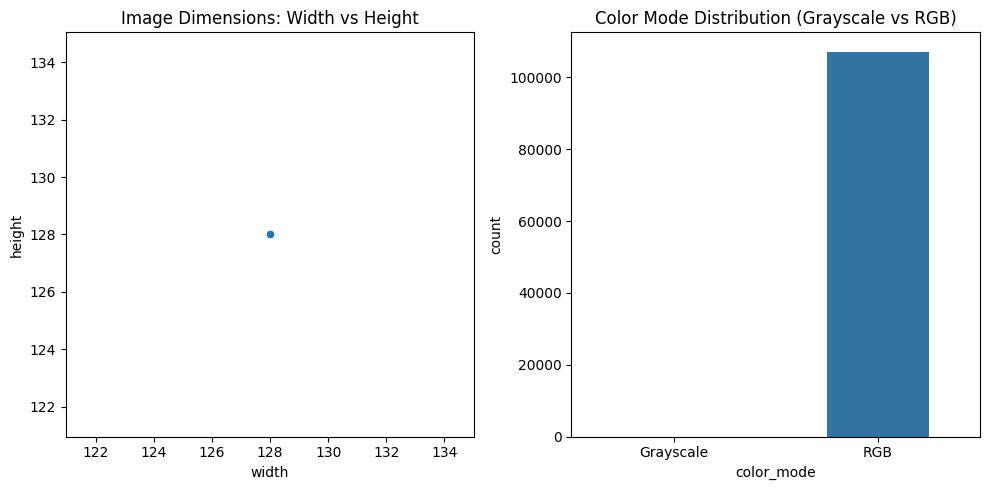

In [7]:
def get_file_hash(filepath):
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def get_image_metadata_from_df(df):
    ext_count = defaultdict(int)
    unique_hashes = {}
    duplicates = []

    df['file_path'] = '/content/class_task/pathmnist_128/' + df['filename']
    df['original_extension'] = ''
    df['width'] = 0
    df['height'] = 0
    df['aspect_ratio'] = 0.0
    df['color_mode'] = ''
    df['is_duplicate'] = False
    df['original_index'] = None

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        filename = row['filename']
        img_path = row['file_path']

        img_hash = get_file_hash(img_path)

        if img_hash in unique_hashes:
            df.at[idx, 'is_duplicate'] = True
            df.at[idx, 'original_index'] = unique_hashes[img_hash]
            duplicates.append({
                'duplicate_idx': idx,
                'original_idx': unique_hashes[img_hash],
                'hash': img_hash
            })
            continue

        unique_hashes[img_hash] = idx

        width, height = imagesize.get(img_path)
        img = Image.open(img_path)
        color_mode = "RGB" if img.mode == "RGB" else "Grayscale"

        ext = os.path.splitext(filename)[1].lower()
        ext_count[ext] += 1

        df.at[idx, 'original_extension'] = ext
        df.at[idx, 'width'] = width
        df.at[idx, 'height'] = height
        df.at[idx, 'aspect_ratio'] = round(width / height, 2)
        df.at[idx, 'color_mode'] = color_mode

    duplicate_summary = {
        'total_duplicates': df['is_duplicate'].sum(),
        'detailed_duplicates': duplicates
    }

    df_clean = df[~df['is_duplicate']].copy()
    df_clean.reset_index(drop=True, inplace=True)

    return df_clean, ext_count, duplicate_summary

def display_duplicate_info(duplicate_summary):
    print("\nDuplicate Analysis:")
    print(f"Total duplicate images found: {duplicate_summary['total_duplicates']}")

    if duplicate_summary['detailed_duplicates']:
        print("\nDetailed duplicate information:")
        for dupe in duplicate_summary['detailed_duplicates']:
            print(f"  Duplicate at index {dupe['duplicate_idx']} is a copy of image at index {dupe['original_idx']}")
    else:
        print("No duplicates found.")

def display_info(img_meta_df, ext_count):
    print("\nFile extension counts:")
    for ext, count in ext_count.items():
        print(f"{ext}: {count} images")

    fig = plt.figure(figsize=(10, 5))
    gs = fig.add_gridspec(1, 2)

    # 1. Scatter plot: Width vs Height
    ax1 = fig.add_subplot(gs[0, 0])
    sns.scatterplot(x="width", y="height", data=img_meta_df, ax=ax1)
    ax1.set_title("Image Dimensions: Width vs Height")

    # 2. Histogram of Color Modes
    ax2 = fig.add_subplot(gs[0, 1])
    img_meta_df['color_mode'] = pd.Categorical(img_meta_df['color_mode'], categories=["Grayscale", "RGB"])
    sns.countplot(x="color_mode", data=img_meta_df, ax=ax2, width=0.5)
    ax2.set_title("Color Mode Distribution (Grayscale vs RGB)")

    plt.tight_layout()
    plt.show()

clean_image_metadata, ext_count, duplicate_summary = get_image_metadata_from_df(raw_image_metadata)
display_duplicate_info(duplicate_summary)
clean_image_metadata.to_csv('clean_image_metadata.csv', index=False)
display_info(clean_image_metadata, ext_count)


 This quick metadata analysis shows how well curated the PathMNIST dataset is: it comprises of more than 100k unique images, all with the same extention, dimensions, and color mode distribution.

# 3. DATA AUGMENTATION AND FEATURE EXTRACTION

In [8]:
from sklearn.model_selection import train_test_split
from pathlib import Path
import albumentations as A
import cv2
import random
from skimage import io, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import shannon_entropy
from skimage.filters import sobel, gabor
from skimage.color import rgb2gray
import mahotas
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import umap
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.tree import DecisionTreeClassifier

TRAINING_TARGET_SIZE = 10000
AUGMENTATION_THRESHOLD = 0.5
MAX_AUGMENTATION_FACTOR = 6
RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

The dataset is already split into training, testing and validating subsets. For more clarification, see the aforementioned dataset's description and class distribution statistics.

In [9]:
clean_image_metadata['set'] = clean_image_metadata['set'].str.upper().map({
    'TRAIN': 'train',
    'TEST': 'test',
    'VALIDATION': 'val'
})

train_df = clean_image_metadata[clean_image_metadata['set'] == 'train'].copy()
val_df = clean_image_metadata[clean_image_metadata['set'] == 'val'].copy()
test_df = clean_image_metadata[clean_image_metadata['set'] == 'test'].copy()

img_updated_metadata = pd.concat([train_df, val_df, test_df], axis=0).reset_index(drop=True)

img_updated_metadata.to_csv('img_updated_metadata.csv', index=False)

## 3.1 Data Augmentation
Given the size of the training dataset, a data augmentation step is not really needed. As a proof of concept, I will carry out simple transformatio-based data augmentation on the less represented classes of the training set. I will then perform feature extraction on the augmented dataset for the 3 ML models and train the CNN directly on these images.

An alternative approach would be to extract features from the original images first, apply feature-level augmentation techniques such as SMOTE (using imblearn), and separately apply more aggressive image augmentation for the CNN. However, this would lead to inconsistencies across the four models due to the differing augmentation strategies.

For the moment, I will prioritise consistency and carry out the first approach, keeping the alternative as a backup plan in case the models perform poorly.

In [10]:
augmentation = A.Compose([
    A.SomeOf([
                            A.RandomRotate90(p=0.5),
                            A.HorizontalFlip(p=0.5),
                            A.OneOf([
                                A.GaussNoise(p=0.3),
                                A.GaussianBlur(blur_limit=(1, 3), p=0.3),
                            ], p=0.3),
                            A.Affine(scale=(0.9, 1.1),
                                     translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
                                     rotate=(-20, 20),
                                     shear={"x": 0, "y": 0}, p=0.5),
                            A.OneOf([
                                A.OpticalDistortion(p=0.2),
                                A.GridDistortion(num_steps=5, distort_limit=0.05, p=0.2),
                            ], p=0.2),
                            A.OneOf([
                                A.CLAHE(clip_limit=2, tile_grid_size=(4, 4), p=0.5),
                                A.RandomBrightnessContrast(p=0.3),
                                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
                            ], p=0.4)
        ], n=4, p=1.0)
])

In [11]:
def apply_augmentation(image_path, save_path):
    try:
        image = cv2.imread(str(image_path))
        if image is None:
            print(f"Failed to read image: {image_path}")
            return False

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented = augmentation(image=image)['image']
        augmented = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)

        cv2.imwrite(str(save_path), augmented)
        return True
    except Exception as e:
        print(f"Failed to augment image: {image_path}, Error: {e}")
        return False

In [12]:
augmented_metadata = []

for class_name in train_df['class'].unique():
    class_df = train_df[train_df['class'] == class_name].copy()
    class_size = len(class_df)

    if class_size < TRAINING_TARGET_SIZE:
        if class_size > TRAINING_TARGET_SIZE * AUGMENTATION_THRESHOLD:
            # classes near the target size
            n_augment = TRAINING_TARGET_SIZE - class_size
            augment_indices = np.random.choice(class_size, size=n_augment, replace=False)

            tqdm_iter = tqdm(range(n_augment), desc=f'Augmenting {class_name} (near target)', leave=True)
            for i, idx in enumerate(augment_indices):
                original_row = class_df.iloc[idx]
                new_path = Path(original_row['file_path'])
                new_path = new_path.parent / f"augm_{new_path.name}"

                if apply_augmentation(original_row['file_path'], new_path):
                    augmented_metadata.append({
                        'file_path': str(new_path),
                        'class': original_row['class'],
                        'set': 'train'
                    })
                tqdm_iter.update(1)
            tqdm_iter.close()

        else:
            augmentation_factor = min(
                MAX_AUGMENTATION_FACTOR,
                int(np.ceil(TRAINING_TARGET_SIZE / class_size))
            )

            total_augmentations = len(class_df) * (augmentation_factor - 1)
            tqdm_iter = tqdm(total=total_augmentations,
                             desc=f'Augmenting {class_name} (low size) ; {augmentation_factor} times',
                             leave=True)

            for _, row in class_df.iterrows():
                for aug_idx in range(augmentation_factor - 1):
                    new_path = Path(row['file_path'])
                    new_path = new_path.parent / f"augm_{aug_idx}_{new_path.name}"

                    if apply_augmentation(row['file_path'], new_path):
                        augmented_metadata.append({
                            'file_path': str(new_path),
                            'class': row['class'],
                            'set': 'train'
                        })
                    tqdm_iter.update(1)
            tqdm_iter.close()

full_metadata = pd.concat([
    pd.DataFrame(augmented_metadata),
    train_df[['file_path', 'class', 'set']],
    val_df[['file_path', 'class', 'set']],
    test_df[['file_path', 'class', 'set']]
], ignore_index=True)

Augmenting 6 (near target): 100%|██████████| 2114/2114 [00:13<00:00, 161.42it/s]



Class distribution in train set:
adipose                  : 10000 samples
background               : 10000 samples
debris                   : 10360 samples
lymphocytes              : 10401 samples
mucus                    : 10000 samples
muscle                   : 12182 samples
mucosa                   : 10000 samples
cas                      : 10000 samples
adenocarcinoma           : 12885 samples


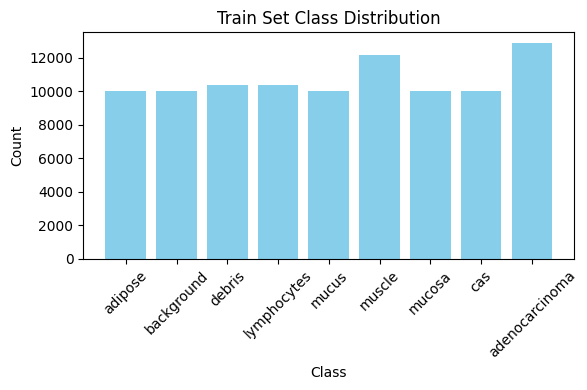

In [13]:
train_dist = compute_class_distribution(full_metadata[full_metadata['set'] == 'train'])
print_distribution(train_dist, "Class distribution in train set")
plot_distribution(train_dist, "Train Set Class Distribution")

In [14]:
full_metadata.to_csv('img_augmented_metadata.csv', index=False)

## 3.2 Feature extraction

To extract features from the labeled images, I adopted a combination of color statistics, global texture descriptors, and local texture patterns.

Each image is read in BGR format, and first order features (mean, std, skewness and kurstosis of pixel intensities) are extracted from each of the three RGB channels.

I will then extract:
- Global texture features using mahotas haralick descriptors. These are global texture features based on pixel adjacency matrix.
- Local texture features from Local Binary Pattern (LBP) histogram and Gabor filter response statistics.

In [15]:
def extract_color_channel_stats(img, features, color_space='BGR'):
    """Extract mean, std, skewness, and kurtosis for each color channel."""
    if color_space == 'BGR' and len(img.shape) == 3:
        channels = cv2.split(img)
        for i, channel in enumerate(['B', 'G', 'R']):
            features[f'{channel}_mean'] = np.mean(channels[i])
            features[f'{channel}_std'] = np.std(channels[i])
            features[f'{channel}_skewness'] = skew(channels[i].ravel())
            features[f'{channel}_kurtosis'] = kurtosis(channels[i].ravel())
    return features

def extract_global_features(gray_img):
    """Extract Haralick features from a grayscale image."""
    features = {}
    haralick = mahotas.features.haralick(gray_img, return_mean=True)
    haralick_feature_names = [
        'ASM', 'Contrast', 'Correlation', 'Variance', 'IDM',
        'SumAverage', 'SumVariance', 'SumEntropy', 'Entropy',
        'DifferenceVariance', 'DifferenceEntropy', 'IMC1', 'IMC2'
    ]
    for i, feature in enumerate(haralick):
        features[f'haralick_{haralick_feature_names[i]}'] = feature
    return features

def extract_texture_features(gray_img):
    """Extract texture features such as LBP histogram and Gabor responses."""
    features = {}

    # LBP (Local Binary Pattern)
    lbp = local_binary_pattern(gray_img, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 11), range=(0, 10), density=True)
    for i, val in enumerate(lbp_hist):
        features[f'lbp_bin_{i}'] = val

    # Gabor (real part statistics)
    gabor_real, _ = gabor(gray_img, frequency=0.6)
    features['gabor_mean'] = np.mean(gabor_real)
    features['gabor_std'] = np.std(gabor_real)
    features['gabor_skewness'] = skew(gabor_real.ravel())
    features['gabor_kurtosis'] = kurtosis(gabor_real.ravel())

    return features

def extract_features(image_path):
    """Master extraction function combining all subfeature blocks."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return None

    features = {}

    # RGB statistics
    features = extract_color_channel_stats(img, features)

    # Grayscale conversion
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if gray_img is None or gray_img.size == 0 or np.count_nonzero(gray_img) == 0:
        print(f"Empty or zero-valued image: {image_path}")
        return None

    # Global features (Haralick)
    features.update(extract_global_features(gray_img))

    # Local texture features (LBP + Gabor)
    features.update(extract_texture_features(gray_img))

    return features

def process_row(row):
    """Wrapper for row-wise processing."""
    features = extract_features(row['file_path'])
    if features is not None:
        return {
            'file_path': row['file_path'],
            'class': row['class'],
            'set': row['set'],
            **features
        }

features_data = []
with ProcessPoolExecutor(max_workers=8) as executor:
    for result in tqdm(executor.map(process_row, [row for _, row in img_updated_metadata.iterrows()]),
                       desc='Extracting features...', total=len(img_updated_metadata)):
        if result:
            features_data.append(result)

features_df = pd.DataFrame(features_data)
features_df.to_csv('features.csv', index=False)


Extracting features...: 100%|██████████| 107180/107180 [3:03:24<00:00,  9.74it/s]


In [16]:
print(features_df.columns)
print('Nan :', features_df.isnull().values.any())
print('Inf :', features_df.isin([-np.inf,np.inf]).values.any())

Index(['file_path', 'class', 'set', 'B_mean', 'B_std', 'B_skewness',
       'B_kurtosis', 'G_mean', 'G_std', 'G_skewness', 'G_kurtosis', 'R_mean',
       'R_std', 'R_skewness', 'R_kurtosis', 'haralick_ASM',
       'haralick_Contrast', 'haralick_Correlation', 'haralick_Variance',
       'haralick_IDM', 'haralick_SumAverage', 'haralick_SumVariance',
       'haralick_SumEntropy', 'haralick_Entropy',
       'haralick_DifferenceVariance', 'haralick_DifferenceEntropy',
       'haralick_IMC1', 'haralick_IMC2', 'lbp_bin_0', 'lbp_bin_1', 'lbp_bin_2',
       'lbp_bin_3', 'lbp_bin_4', 'lbp_bin_5', 'lbp_bin_6', 'lbp_bin_7',
       'lbp_bin_8', 'lbp_bin_9', 'gabor_mean', 'gabor_std', 'gabor_skewness',
       'gabor_kurtosis'],
      dtype='object')
Nan : False
Inf : False


## 3.3 Feature analysis

In [8]:
features_df= pd.read_csv('features.csv')
print(features_df.columns)
augmented_metadata = pd.read_csv('img_augmented_metadata.csv')
features = list(features_df.drop(['set', 'class', 'file_path'], axis=1).columns)
scaler = StandardScaler()
decode_fn = np.vectorize(class_names.get)

# train set
X_train_features = scaler.fit_transform(features_df[features_df['set'] == 'train'].drop(['set', 'class', 'file_path'], axis=1))
y_train_encoded = np.array(features_df[features_df['set'] == 'train']['class'])
y_train_decoded = decode_fn(y_train_encoded)

X_train_images = augmented_metadata[augmented_metadata['set'] == 'train']
y_train_encoded_images = np.array(augmented_metadata[augmented_metadata['set'] == 'train']['class'])
y_train_decoded_images = decode_fn(y_train_encoded_images)

print(X_train_features.shape)
print(X_train_images.shape)

# validation set
X_val_features = scaler.transform(features_df[features_df['set'] == 'val'].drop(['set', 'class', 'file_path'], axis=1))
y_val_encoded = np.array(features_df[features_df['set'] == 'val']['class'])
y_val_decoded = decode_fn(y_val_encoded)

X_val_images = augmented_metadata[augmented_metadata['set'] == 'val']
y_val_encoded_images = np.array(augmented_metadata[augmented_metadata['set'] == 'val']['class'])
y_val_decoded_images = decode_fn(y_val_encoded_images)

print(X_val_features.shape)

# test set
X_test_features = scaler.transform(features_df[features_df['set'] == 'test'].drop(['set', 'class', 'file_path'], axis=1))
y_test_encoded = np.array(features_df[features_df['set'] == 'test']['class'])
y_test_decoded = decode_fn(y_test_encoded)

X_test_images = augmented_metadata[augmented_metadata['set'] == 'test']
y_test_encoded_images = np.array(augmented_metadata[augmented_metadata['set'] == 'test']['class'])
y_test_decoded_images = decode_fn(y_test_encoded_images)

print(X_test_features.shape)

Index(['file_path', 'class', 'set', 'B_mean', 'B_std', 'B_skewness',
       'B_kurtosis', 'G_mean', 'G_std', 'G_skewness', 'G_kurtosis', 'R_mean',
       'R_std', 'R_skewness', 'R_kurtosis', 'haralick_ASM',
       'haralick_Contrast', 'haralick_Correlation', 'haralick_Variance',
       'haralick_IDM', 'haralick_SumAverage', 'haralick_SumVariance',
       'haralick_SumEntropy', 'haralick_Entropy',
       'haralick_DifferenceVariance', 'haralick_DifferenceEntropy',
       'haralick_IMC1', 'haralick_IMC2', 'lbp_bin_0', 'lbp_bin_1', 'lbp_bin_2',
       'lbp_bin_3', 'lbp_bin_4', 'lbp_bin_5', 'lbp_bin_6', 'lbp_bin_7',
       'lbp_bin_8', 'lbp_bin_9', 'gabor_mean', 'gabor_std', 'gabor_skewness',
       'gabor_kurtosis'],
      dtype='object')
(89996, 39)
(95828, 3)
(10004, 39)
(7180, 39)


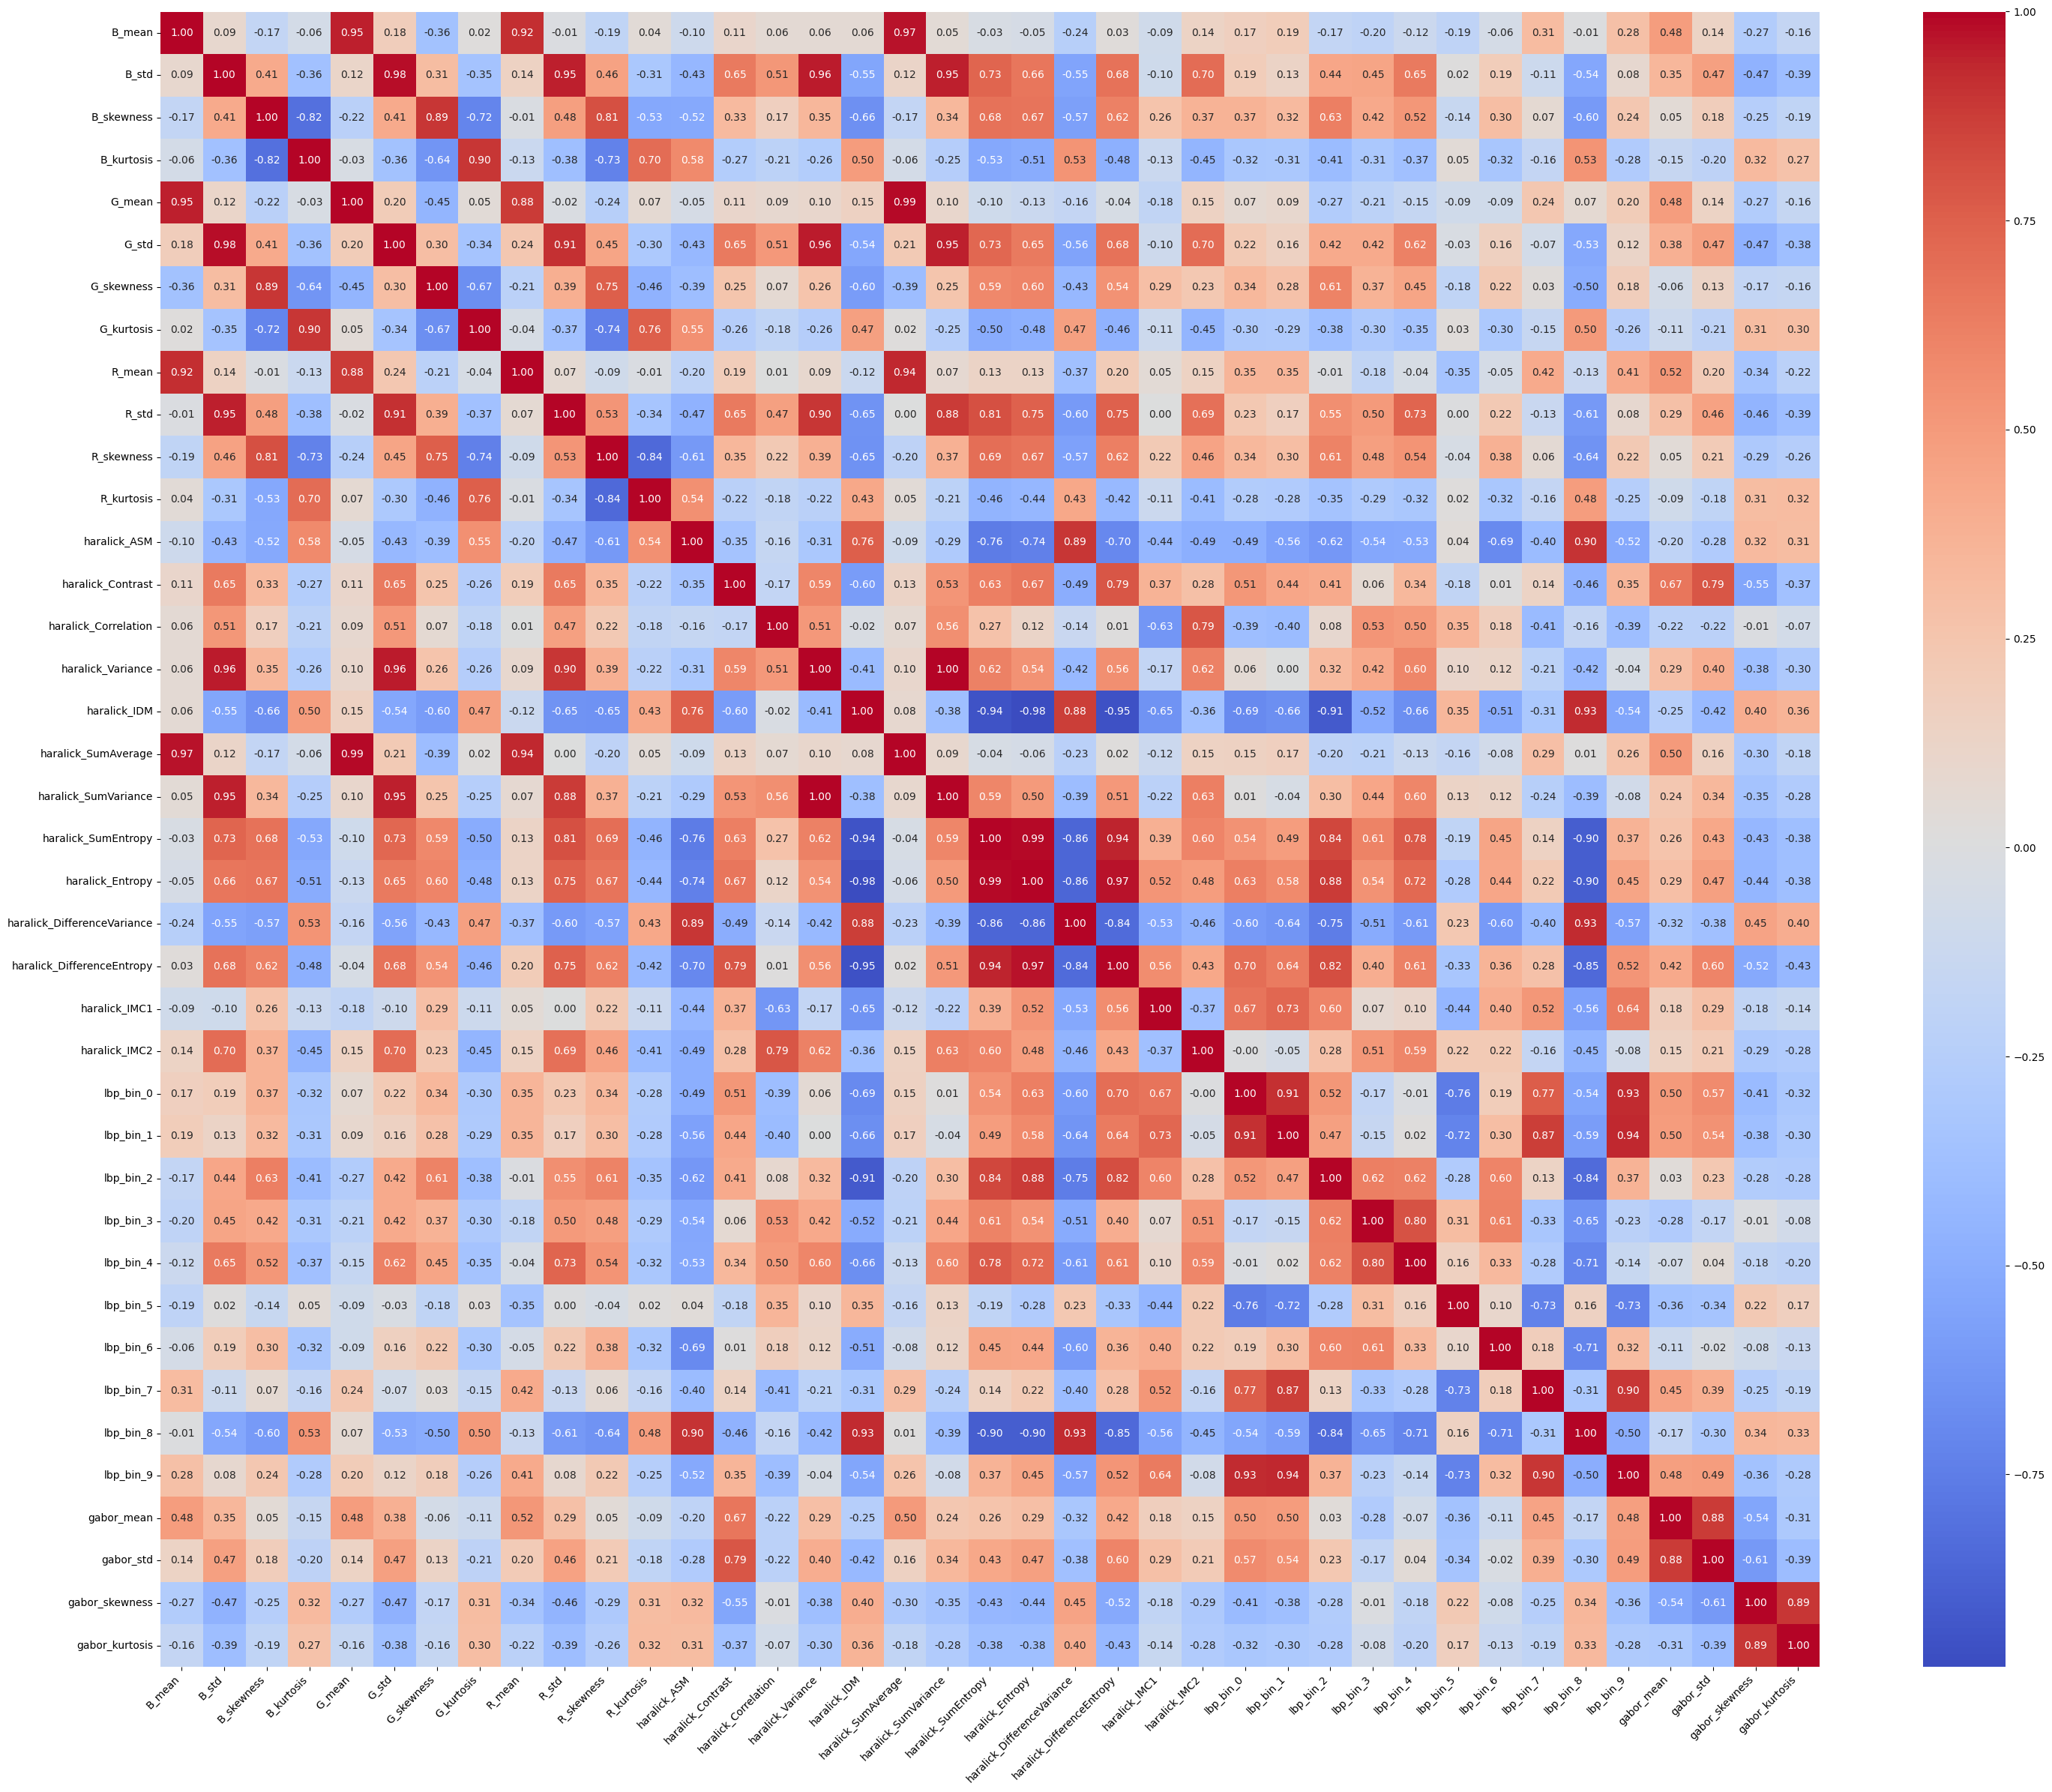

In [15]:
# Heatmap visualization of the correlation matrix of the training features
features_df_train = pd.DataFrame(X_train_features, columns = features)
corr_matrix = features_df_train.corr()

plt.figure(figsize=(30, 24))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

We can see how many features correlate with each other. Highly correlated features will be removed to slim down the feature set.

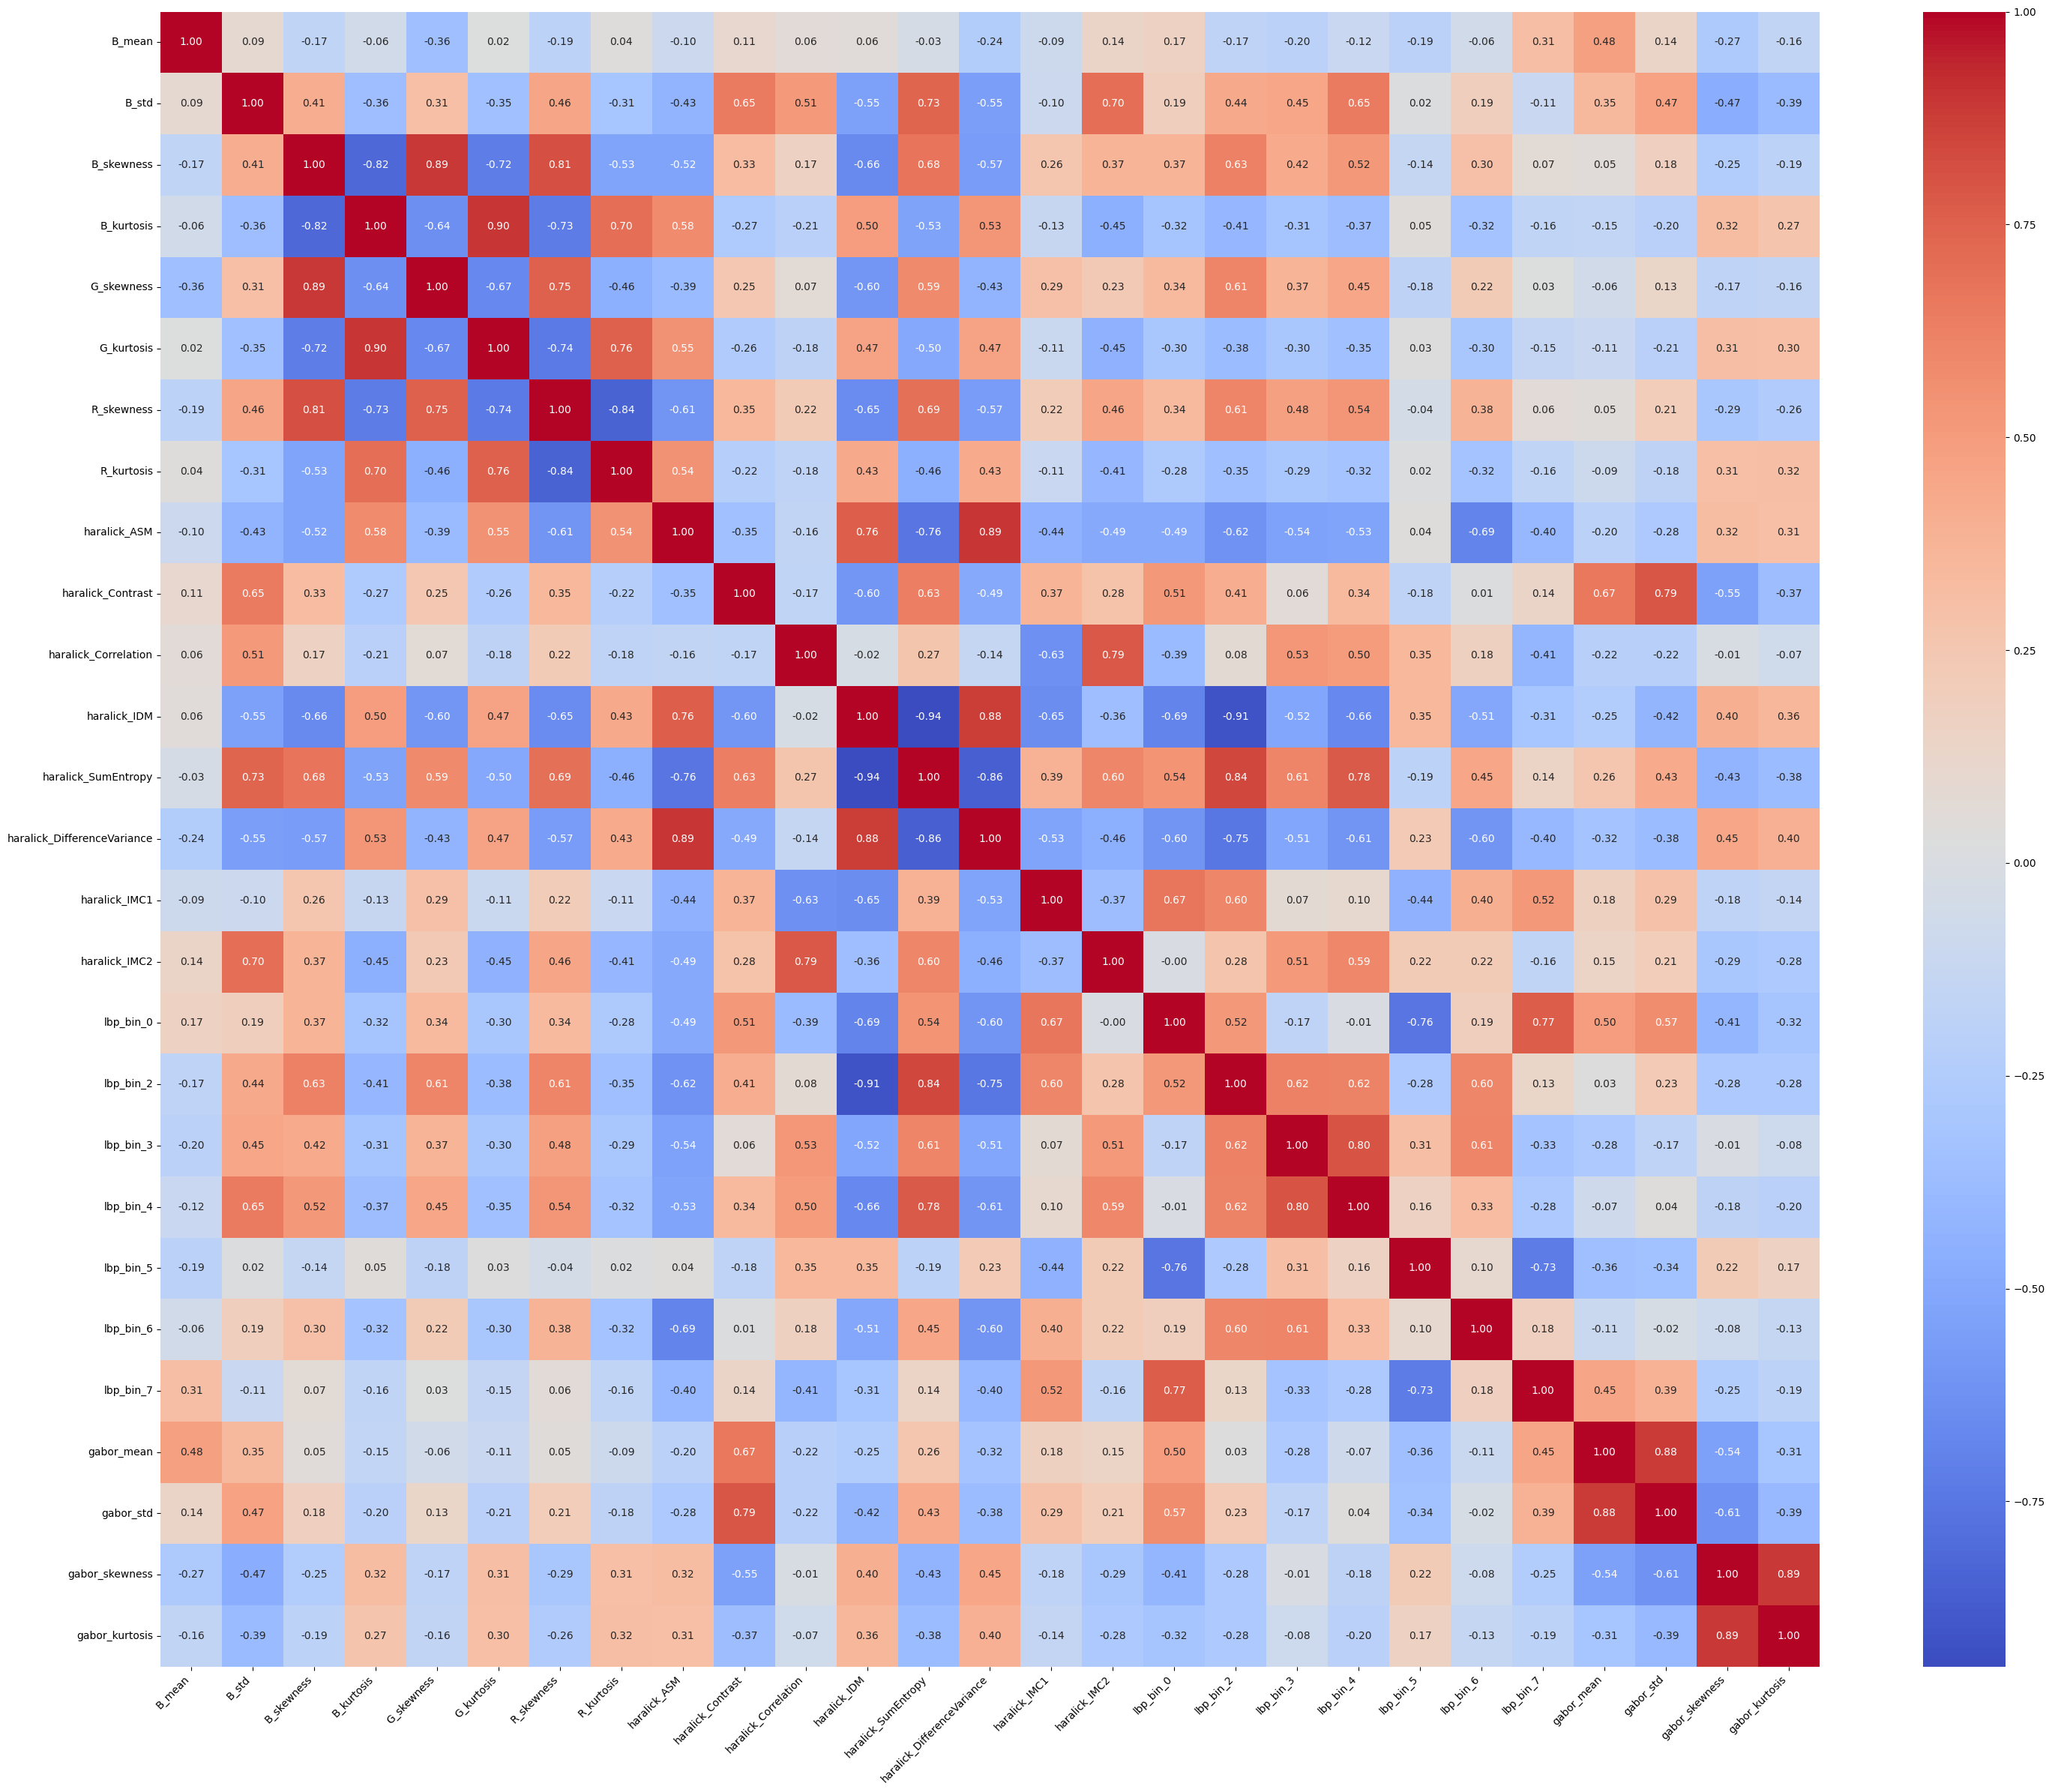

In [16]:
# Removes highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
features_df_dropped = features_df_train.drop(columns=to_drop)
corr_matrix_dropped = features_df_dropped.corr()
plt.figure(figsize=(30, 24))
sns.heatmap(corr_matrix_dropped, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:
to_drop.extend(['set', 'class', 'file_path'])
to_drop = list(set(to_drop))
features_df= pd.read_csv('features.csv')
augmented_metadata = pd.read_csv('img_augmented_metadata.csv')
augmented_metadata = augmented_metadata[~augmented_metadata['file_path'].str.contains('synthetic')]
features = list(features_df.drop(columns=to_drop).columns)
scaler = StandardScaler()

# train
X_train_features = scaler.fit_transform(features_df[features_df['set'] == 'train'].drop(columns=to_drop))
y_train_encoded = np.array(features_df[features_df['set'] == 'train']['class'])
y_train_decoded = decode_fn(y_train_encoded)

X_train_images = augmented_metadata[augmented_metadata['set'] == 'train']
y_train_encoded_images = np.array(augmented_metadata[augmented_metadata['set'] == 'train']['class'])
y_train_decoded_images = decode_fn(y_train_encoded_images)

print(X_train_features.shape)
print(X_train_images.shape)

# val
X_val_features = scaler.transform(features_df[features_df['set'] == 'val'].drop(columns=to_drop))
y_val_encoded = np.array(features_df[features_df['set'] == 'val']['class'])
y_val_decoded = decode_fn(y_val_encoded)

X_val_images = augmented_metadata[augmented_metadata['set'] == 'val']
y_val_encoded_images = np.array(augmented_metadata[augmented_metadata['set'] == 'val']['class'])
y_val_decoded_images = decode_fn(y_val_encoded_images)

print(X_val_features.shape)

# test
X_test_features = scaler.transform(features_df[features_df['set'] == 'test'].drop(columns=to_drop))
y_test_encoded = np.array(features_df[features_df['set'] == 'test']['class'])
y_test_decoded = decode_fn(y_test_encoded)

X_test_images = augmented_metadata[augmented_metadata['set'] == 'test']
y_test_encoded_images = np.array(augmented_metadata[augmented_metadata['set'] == 'test']['class'])
y_test_decoded_images = decode_fn(y_test_encoded_images)

print(X_test_features.shape)
print(f'these {len(to_drop)} features have been dropped', to_drop)

(89996, 27)
(95828, 3)
(10004, 27)
(7180, 27)
these 15 features have been dropped ['haralick_Entropy', 'haralick_SumAverage', 'set', 'haralick_SumVariance', 'G_mean', 'lbp_bin_9', 'class', 'lbp_bin_1', 'file_path', 'haralick_Variance', 'haralick_DifferenceEntropy', 'R_std', 'G_std', 'lbp_bin_8', 'R_mean']


# 4. Dimensionality reduction

Now, let's take a closer look to the extracted features. Dimensionality reduction is performed to have a more comprehensible view of the feature set.

Explained variance: [3.95071674e-01 1.75978155e-01 1.07884810e-01 7.68006279e-02
 5.95653956e-02 4.12833982e-02 3.57989999e-02 2.38874821e-02
 1.78254977e-02 1.31975950e-02 1.03174737e-02 9.34345678e-03
 7.70541085e-03 5.22887865e-03 3.88264522e-03 3.24895275e-03
 2.41662793e-03 2.13793904e-03 1.67087974e-03 1.59051303e-03
 1.24834884e-03 1.13137498e-03 1.01403977e-03 7.51300090e-04
 5.82381133e-04 3.31288471e-04 1.04854225e-04]


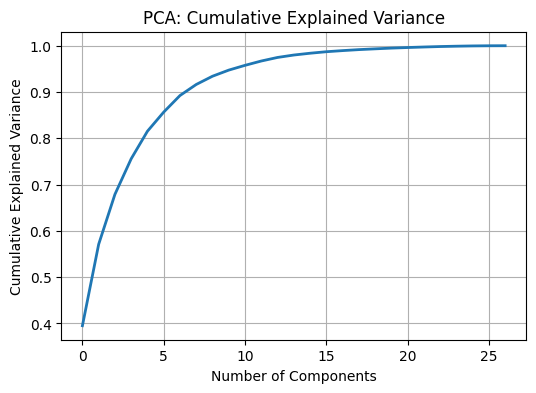

Number of components to explain 95% of variance: 11
Number of components to explain 99% of variance: 18


In [21]:
pca = PCA(n_components=None)
pca.fit(X_train_features)

explained_variance = pca.explained_variance_ratio_
print('Explained variance:', explained_variance)

cumulative_variance = np.cumsum(explained_variance)
plt.figure(figsize=(6, 4))
plt.plot(cumulative_variance, linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.grid(True)
plt.show()

explained_variance_95 = np.argmax(cumulative_variance >= 0.95) + 1
explained_variance_99 = np.argmax(cumulative_variance >= 0.99) + 1

print(f'Number of components to explain 95% of variance: {explained_variance_95}')
print(f'Number of components to explain 99% of variance: {explained_variance_99}')

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
def stratified_sample(X, y, frac=0.1, random_state=42):
    np.random.seed(random_state)
    classes = np.unique(y)
    sampled_X, sampled_y = [], []

    for c in classes:
        idx = np.where(y == c)[0]
        n = max(1, int(len(idx) * frac))
        sampled_idx = np.random.choice(idx, size=n, replace=False)
        sampled_X.append(X[sampled_idx])
        sampled_y.append(y[sampled_idx])

    return np.vstack(sampled_X), np.concatenate(sampled_y)

X_subset, y_subset = stratified_sample(X_train_features, y_train_encoded, frac=0.25)

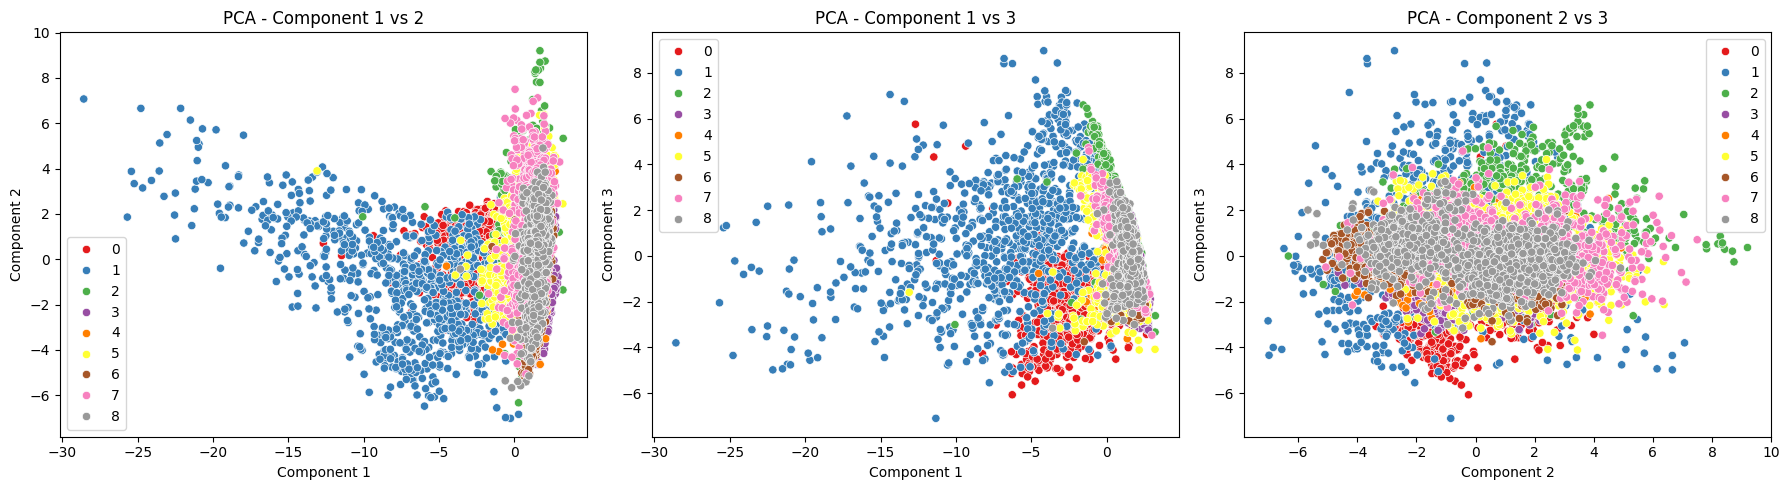

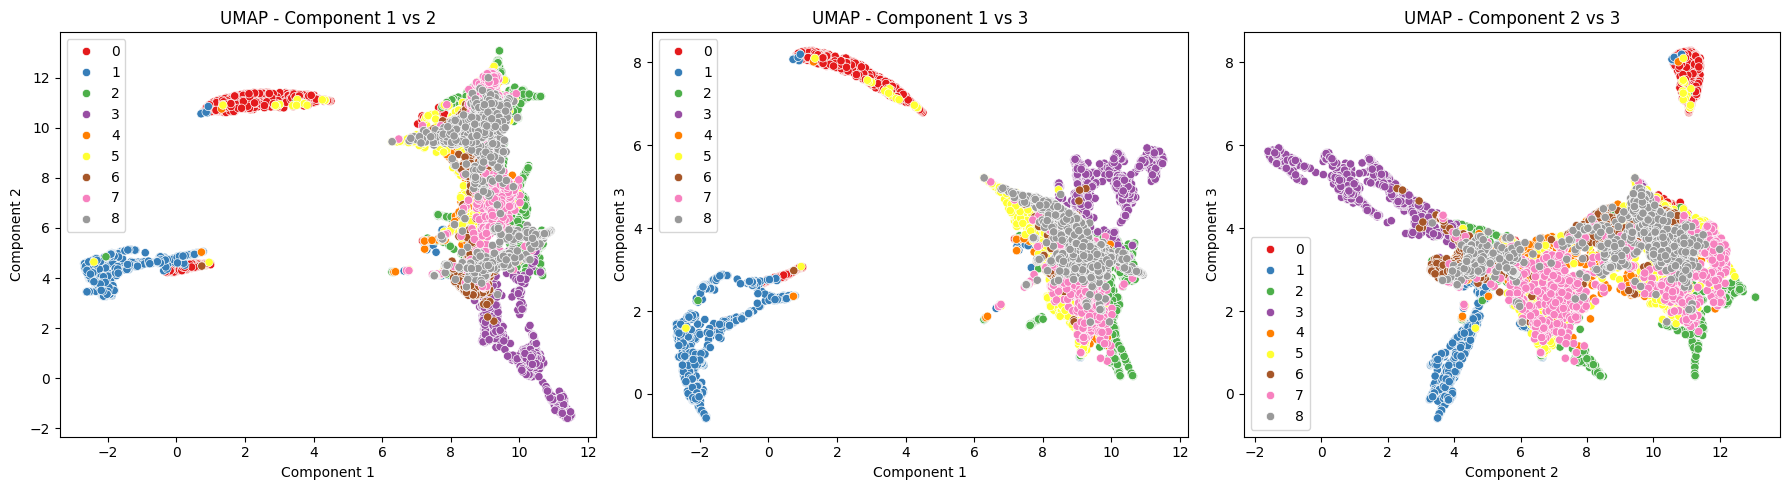

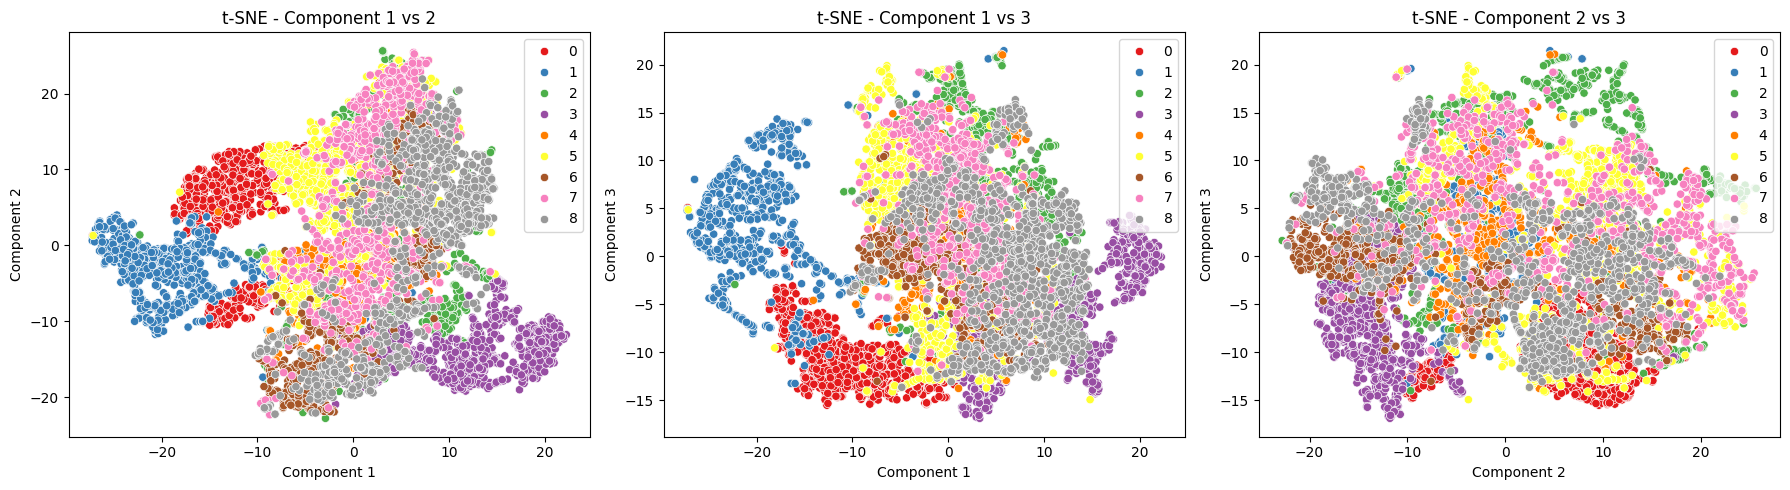

In [36]:
# PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_subset)

# UMAP
umap_model = umap.UMAP(n_components=10, random_state=42)
X_umap = umap_model.fit_transform(X_subset)

# t-SNE
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_subset)

def plot_components(X_reduced, title):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # components 1 vs 2
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y_subset, ax=axs[0], palette='Set1')
    axs[0].set_title(f'{title} - Component 1 vs 2')
    axs[0].set_xlabel('Component 1')
    axs[0].set_ylabel('Component 2')

    # components 1 vs 3
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 2], hue=y_subset, ax=axs[1], palette='Set1')
    axs[1].set_title(f'{title} - Component 1 vs 3')
    axs[1].set_xlabel('Component 1')
    axs[1].set_ylabel('Component 3')

    # components 2 vs 3
    sns.scatterplot(x=X_reduced[:, 1], y=X_reduced[:, 2], hue=y_subset, ax=axs[2], palette='Set1')
    axs[2].set_title(f'{title} - Component 2 vs 3')
    axs[2].set_xlabel('Component 2')
    axs[2].set_ylabel('Component 3')

    plt.tight_layout()
    plt.show()

plot_components(X_pca, 'PCA')

plot_components(X_umap, 'UMAP')

plot_components(X_tsne, 't-SNE')

In [37]:
feature_importances = pd.DataFrame(columns=features)

for i in tqdm(range(100), total=100):
    feature_sel_tree = DecisionTreeClassifier()
    feature_sel_tree.fit(X_train_features, y_train_encoded)

    temp_importances = pd.Series(feature_sel_tree.feature_importances_, index=features)
    temp_importances= pd.DataFrame(temp_importances).T
    feature_importances = pd.concat([feature_importances, temp_importances], ignore_index=True)

feature_importances = feature_importances.mean().sort_values(ascending=False)
feature_importances.to_csv('feature_importances.csv', index=False)
feature_importances

100%|██████████| 100/100 [18:02<00:00, 10.83s/it]


G_skewness                     0.153268
lbp_bin_5                      0.124138
haralick_Contrast              0.121846
R_kurtosis                     0.076324
lbp_bin_2                      0.047146
lbp_bin_4                      0.044841
B_skewness                     0.042965
B_mean                         0.040019
lbp_bin_3                      0.038347
haralick_SumEntropy            0.036978
lbp_bin_6                      0.035255
R_skewness                     0.033556
haralick_Correlation           0.024371
gabor_std                      0.021411
lbp_bin_7                      0.020276
B_kurtosis                     0.017991
haralick_DifferenceVariance    0.017522
haralick_IDM                   0.015239
haralick_IMC2                  0.013334
gabor_mean                     0.013302
haralick_IMC1                  0.012611
G_kurtosis                     0.012588
B_std                          0.011034
haralick_ASM                   0.009718
lbp_bin_0                      0.009132
gabor_kurtosis                 0.003443
gabor_skewness                 0.003344
dtype: float64

In [65]:
# CHECKPOINT SAVE
X_train_images.to_csv('X_train_images.csv', index=False)
X_val_images.to_csv('X_val_images.csv', index=False)
X_test_images.to_csv('X_test_images.csv', index=False)

np.save('y_train_encoded_images.npy', y_train_encoded_images)
np.save('y_train_dencoded_images.npy', y_train_decoded_images)
np.save('y_val_encoded_images.npy', y_val_encoded_images)
np.save('y_val_decoded_images.npy', y_val_decoded_images)
np.save('y_test_encoded_images.npy', y_test_encoded_images)
np.save('y_test_decoded_images.npy', y_test_decoded_images)

pd.DataFrame(X_train_features).to_csv('X_train_features.csv', index=False)
pd.DataFrame(X_val_features).to_csv('X_val_features.csv', index=False)
pd.DataFrame(X_test_features).to_csv('X_test_features.csv', index=False)

pd.DataFrame(y_train_encoded).to_csv('y_train_encoded.csv', index=False)
pd.DataFrame(y_train_decoded).to_csv('y_train_decoded.csv', index=False)
pd.DataFrame(y_val_encoded).to_csv('y_val_encoded.csv', index=False)
pd.DataFrame(y_val_decoded).to_csv('y_val_decoded.csv', index=False)
pd.DataFrame(y_test_encoded).to_csv('y_test_encoded.csv', index=False)
pd.DataFrame(y_test_decoded).to_csv('y_test_decoded.csv', index=False)

In [89]:
# Upload the dataset to the drive
import tarfile
with tarfile.open('/content/class_task.tar.gz', 'w:gz') as tar:
    tar.add('/content/class_task', arcname='class_task')

!mv /content/class_task.tar.gz /content/drive/MyDrive/aml_project/class_task_new.tar.gz

In [4]:
# Import the dataset from the drive
!cp /content/drive/MyDrive/aml_project/class_task_new.tar.gz /content/
!mv /content/class_task_new.tar.gz /content/class_task.tar.gz
!tar -xzf /content/class_task.tar.gz -C /content/ && rm /content/class_task.tar.gz

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization, Activation,
                                     Dropout, GlobalAveragePooling2D, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2
from keras.metrics import F1Score  # Note: `F1Score` is part of KerasCV or TF Addons depending on your setup

import pandas as pd  # Needed for the DataFrame inputs (X_train_images, etc.)
import os
import numpy as np

# checkpoint_dir = "/content/hist_class/"
%cd /content/class_task
# Load features and labels from checkpoint
X_train_images = pd.read_csv('X_train_images.csv')
X_val_images = pd.read_csv('X_val_images.csv')
X_test_images = pd.read_csv('X_test_images.csv')

X_train_features = pd.read_csv('X_train_features.csv')
X_val_features = pd.read_csv('X_val_features.csv')
X_test_features = pd.read_csv('X_test_features.csv')

y_train_encoded = pd.read_csv('y_train_encoded.csv')
y_train_decoded = pd.read_csv('y_train_decoded.csv')
y_val_encoded = pd.read_csv('y_val_encoded.csv')
y_val_decoded = pd.read_csv('y_val_decoded.csv')
y_test_encoded = pd.read_csv('y_test_encoded.csv')
y_test_decoded = pd.read_csv('y_test_decoded.csv')

y_train_encoded_images = np.load('y_train_encoded_images.npy')
y_train_decoded_images = np.load('y_train_dencoded_images.npy', allow_pickle=True)
y_val_encoded_images = np.load('y_val_encoded_images.npy')
y_val_decoded_images = np.load('y_val_decoded_images.npy', allow_pickle=True)
y_test_encoded_images = np.load('y_test_encoded_images.npy')
y_test_decoded_images = np.load('y_test_decoded_images.npy', allow_pickle=True)

/content/class_task


In [12]:

# CHECKPOINT LOAD
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import imagesize
from collections import defaultdict
import hashlib
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from sklearn.model_selection import train_test_split
from pathlib import Path
import albumentations as A
import cv2
import random
from skimage import io, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import shannon_entropy
from skimage.filters import sobel, gabor
from skimage.color import rgb2gray
import mahotas
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import umap
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.tree import DecisionTreeClassifier
import shutil
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# checkpoint_dir = "/content/hist_class/"
%cd /content/class_task

# Load features and labels from checkpoint
X_train_images = pd.read_csv('X_train_images.csv')
X_val_images = pd.read_csv('X_val_images.csv')
X_test_images = pd.read_csv('X_test_images.csv')

X_train_features = pd.read_csv('X_train_features.csv')
X_val_features = pd.read_csv('X_val_features.csv')
X_test_features = pd.read_csv('X_test_features.csv')

y_train_encoded = pd.read_csv('y_train_encoded.csv')
y_train_decoded = pd.read_csv('y_train_decoded.csv')
y_val_encoded = pd.read_csv('y_val_encoded.csv')
y_val_decoded = pd.read_csv('y_val_decoded.csv')
y_test_encoded = pd.read_csv('y_test_encoded.csv')
y_test_decoded = pd.read_csv('y_test_decoded.csv')

y_train_encoded_images = np.load('y_train_encoded_images.npy')
y_train_decoded_images = np.load('y_train_dencoded_images.npy', allow_pickle=True)
y_val_encoded_images = np.load('y_val_encoded_images.npy')
y_val_decoded_images = np.load('y_val_decoded_images.npy', allow_pickle=True)
y_test_encoded_images = np.load('y_test_encoded_images.npy')
y_test_decoded_images = np.load('y_test_decoded_images.npy', allow_pickle=True)

/content/class_task


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 5. Training the models

In [9]:
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, register_keras_serializable
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.regularizers import l2

##5.1 Extreme Gradient Boosting

In [66]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

n_classes = len(np.unique(y_val_encoded))

'''
Here I already carried out a grid search and found the best hyperparameters among the following.
xgb_hparams = {
    'n_estimators': [500, 750, 1000],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}
I will include a very fast grid search as an example.
'''

xgb = XGBClassifier(objective='multi:softprob', num_class=n_classes, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_hparams = {
    'n_estimators': [1000],
    'max_depth': [6],
    'learning_rate': [0.075, 0.1, 0.125],
    'subsample': [0.7],
    'colsample_bytree': [0.9]
}

xgb_grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_hparams,
    scoring='f1_macro',
    cv=5,
    refit=True,
    verbose=10
)

xgb_grid_search.fit(X_train_features, y_train_encoded)

gs_xgb_df = pd.DataFrame(xgb_grid_search.cv_results_)
gs_xgb_df.to_csv('gridSearch_xgb_df.csv', index=False)
gs_xgb_df.sort_values(by='mean_test_score', ascending=False)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START colsample_bytree=0.9, learning_rate=0.075, max_depth=6, n_estimators=1000, subsample=0.7
[CV 1/5; 1/3] END colsample_bytree=0.9, learning_rate=0.075, max_depth=6, n_estimators=1000, subsample=0.7;, score=0.962 total time= 2.6min
[CV 2/5; 1/3] START colsample_bytree=0.9, learning_rate=0.075, max_depth=6, n_estimators=1000, subsample=0.7
[CV 2/5; 1/3] END colsample_bytree=0.9, learning_rate=0.075, max_depth=6, n_estimators=1000, subsample=0.7;, score=0.965 total time= 2.5min
[CV 3/5; 1/3] START colsample_bytree=0.9, learning_rate=0.075, max_depth=6, n_estimators=1000, subsample=0.7
[CV 3/5; 1/3] END colsample_bytree=0.9, learning_rate=0.075, max_depth=6, n_estimators=1000, subsample=0.7;, score=0.965 total time= 2.5min
[CV 4/5; 1/3] START colsample_bytree=0.9, learning_rate=0.075, max_depth=6, n_estimators=1000, subsample=0.7
[CV 4/5; 1/3] END colsample_bytree=0.9, learning_rate=0.075, max_depth=6, n_estimato

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2     137.934280      1.018322         4.462127        0.492032   
1     142.733230      1.430777         4.417602        0.499832   
0     148.371403      2.565684         4.054541        0.057771   

   param_colsample_bytree  param_learning_rate  param_max_depth  \
2                     0.9                0.125                6   
1                     0.9                0.100                6   
0                     0.9                0.075                6   

   param_n_estimators  param_subsample  \
2                1000              0.7   
1                1000              0.7   
0                1000              0.7   

                                              params  split0_test_score  \
2  {'colsample_bytree': 0.9, 'learning_rate': 0.1...           0.962623   
1  {'colsample_bytree': 0.9, 'learning_rate': 0.1...           0.962563   
0  {'colsample_bytree': 0.9, 'learning_rate': 0.0...           0.961813   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
2           0.964368           0.965357           0.967014           0.964963   
1           0.964930           0.965534           0.966297           0.964529   
0           0.965027           0.964682           0.965465           0.963552   

   mean_test_score  std_test_score  rank_test_score  
2         0.964865        0.001425                1  
1         0.964771        0.001254                2  
0         0.964108        0.001311                3

In [79]:
best_xgb = xgb_grid_search.best_estimator_
best_xgb.fit(X_train_features, y_train_encoded)

y_pred_xgb = best_xgb.predict(X_val_features)
y_proba_xgb = best_xgb.predict_proba(X_val_features)

y_pred_xgb_decoded = decode_fn(y_pred_xgb)

# Evaluation
print(classification_report(y_val_decoded, y_pred_xgb_decoded))

                precision    recall  f1-score   support

adenocarcinoma       0.97      0.96      0.96      1432
       adipose       1.00      1.00      1.00      1041
    background       1.00      1.00      1.00      1057
           cas       0.95      0.95      0.95      1045
        debris       0.98      0.97      0.97      1152
   lymphocytes       0.99      0.99      0.99      1156
        mucosa       0.94      0.94      0.94       877
         mucus       0.95      0.97      0.96       890
        muscle       0.97      0.97      0.97      1354

      accuracy                           0.97     10004
     macro avg       0.97      0.97      0.97     10004
  weighted avg       0.97      0.97      0.97     10004



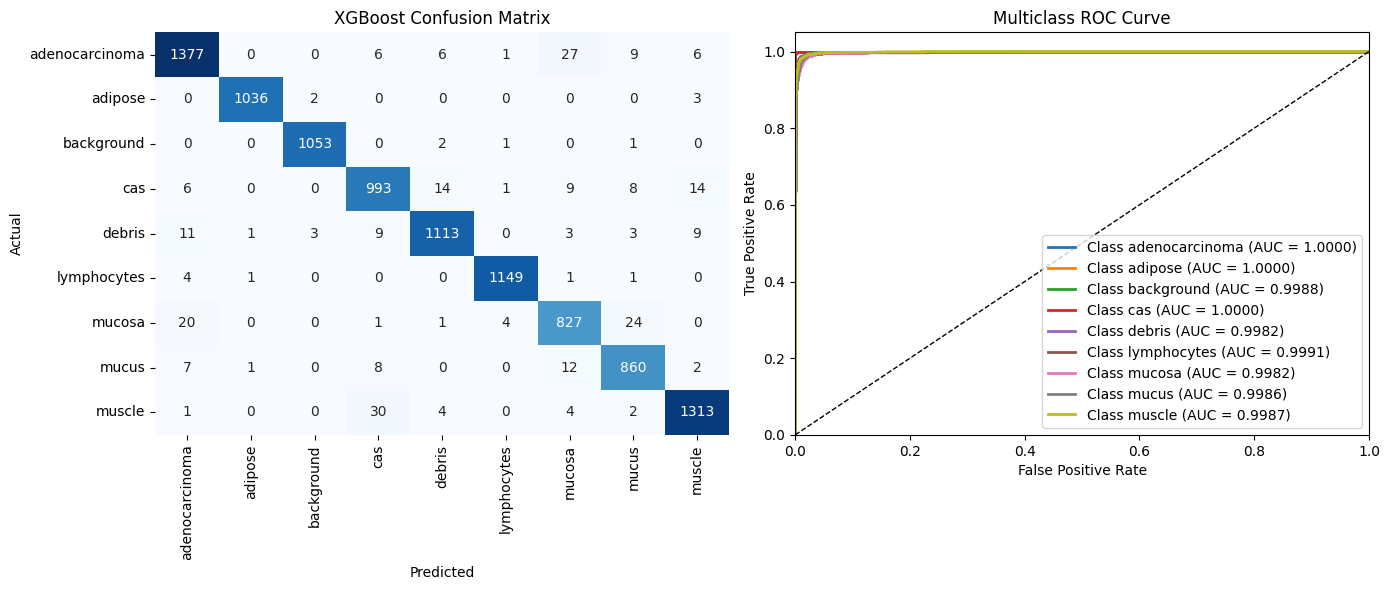

In [80]:
class_names_ = sorted(np.unique(y_val_decoded))
y_val_bin = label_binarize(y_val_encoded, classes=range(len(class_names_)))
n_classes = y_val_bin.shape[1]

cm_xgb = confusion_matrix(y_val_decoded, y_pred_xgb_decoded)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_proba_xgb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g',
            xticklabels=class_names_, yticklabels=class_names_, cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("XGBoost Confusion Matrix")

for i in range(n_classes):
    axes[1].plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names_[i]} (AUC = {roc_auc[i]:.4f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Multiclass ROC Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [81]:
import pickle

with open('best_xgb.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

##5.2 k-NN

In [23]:
def stratified_sample(X, y, frac=0.1, random_state=42):
    np.random.seed(random_state)
    classes = np.unique(y)
    sampled_X, sampled_y = [], []

    for c in classes:
        idx = np.where(y == c)[0]
        n = max(1, int(len(idx) * frac))
        sampled_idx = np.random.choice(idx, size=n, replace=False)
        sampled_X.append(X[sampled_idx])
        sampled_y.append(y[sampled_idx])

    return np.vstack(sampled_X), np.concatenate(sampled_y)

X_subset, y_subset = stratified_sample(X_train_features, y_train_encoded, frac=0.25)

In [24]:
knn = KNeighborsClassifier()

knn_hparams = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'p': [1, 2]  # only used if metric='minkowski'
}


knn_grid_search = GridSearchCV(estimator=knn,
                                param_grid=knn_hparams,
                                scoring='f1_macro',
                                cv=5,
                                refit=True,
                                verbose=0)

knn_grid_search.fit(X_subset, y_subset)

gs_knn_df = pd.DataFrame(knn_grid_search.cv_results_)
gs_knn_df.to_csv('gridSearch_knn_df.csv', index=False)

print("Best parameters:", knn_grid_search.best_params_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


In [82]:
best_knn = knn_grid_search.best_estimator_
best_knn.fit(X_train_features, y_train_encoded)

y_pred_knn = best_knn.predict(X_val_features)
y_proba_knn = best_knn.predict_proba(X_val_features)

y_pred__knn_decoded = decode_fn(y_pred_knn)

# Print classification report
print(classification_report(y_val_decoded, y_pred__knn_decoded))

                precision    recall  f1-score   support

adenocarcinoma       0.89      0.92      0.91      1432
       adipose       0.99      0.99      0.99      1041
    background       1.00      0.99      1.00      1057
           cas       0.87      0.87      0.87      1045
        debris       0.96      0.92      0.94      1152
   lymphocytes       0.98      0.99      0.99      1156
        mucosa       0.82      0.92      0.86       877
         mucus       0.90      0.84      0.87       890
        muscle       0.93      0.90      0.92      1354

      accuracy                           0.93     10004
     macro avg       0.93      0.93      0.93     10004
  weighted avg       0.93      0.93      0.93     10004



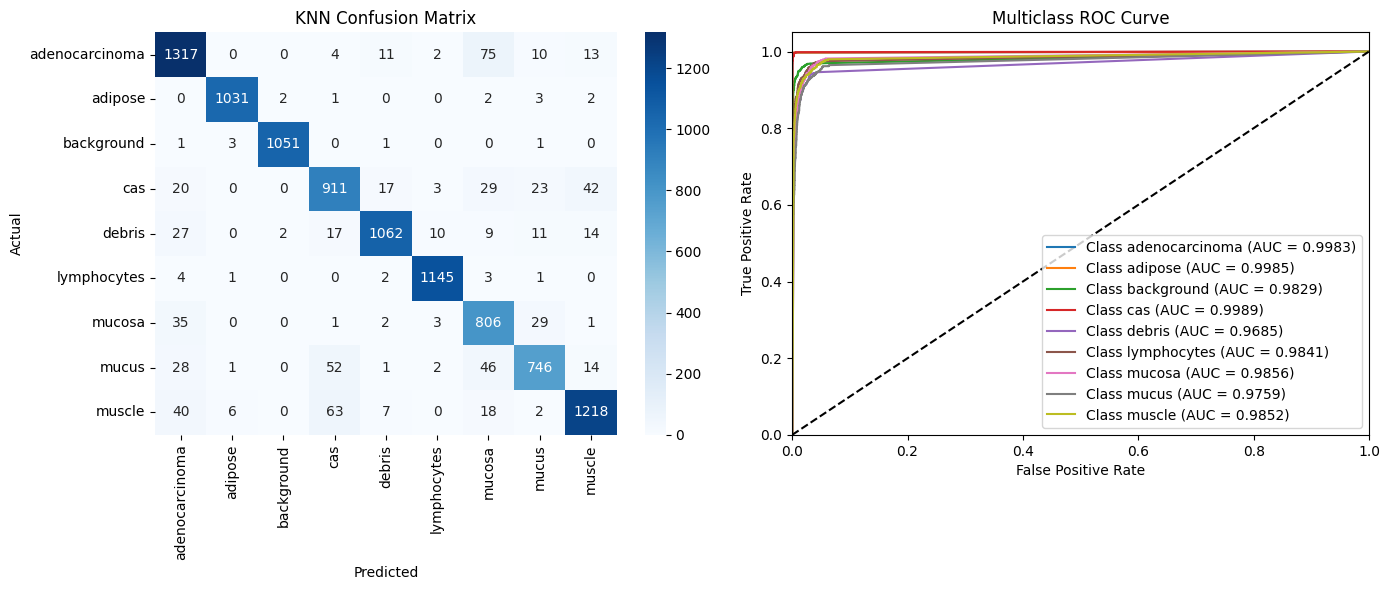

In [83]:
cm_knn = confusion_matrix(y_val_decoded, y_pred__knn_decoded)

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_proba_knn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_knn, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names_, yticklabels=class_names_, ax=axes[0])
axes[0].set_title("KNN Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

for i in range(n_classes):
    axes[1].plot(fpr[i], tpr[i], label=f'Class {class_names_[i]} (AUC = {roc_auc[i]:.4f})')

axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Multiclass ROC Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


In [84]:
with open('best_knn.pkl', 'wb') as f:
    pickle.dump(best_knn, f)

## 5.3 SVC

In [14]:
def stratified_sample(X, y, frac=0.25, random_state=42):
    np.random.seed(random_state)
    classes = np.unique(y)
    sampled_X, sampled_y = [], []

    for c in classes:
        idx = np.where(y == c)[0]
        n = max(1, int(len(idx) * frac))
        sampled_idx = np.random.choice(idx, size=n, replace=False)
        sampled_X.append(X.iloc[sampled_idx])
        sampled_y.append(y.iloc[sampled_idx])

    return pd.concat(sampled_X), pd.concat(sampled_y)

X_subset, y_subset = stratified_sample(X_train_features, y_train_encoded, frac=0.25)

In [15]:
svm_param_grid = [
    {'C': [ 10, 100, 1000],
     'gamma': [0.1, 1,10,100],
     'kernel': ['rbf']},  # no degree for rbf
    {'C': [10, 100, 1000],
     'gamma': [0.1, 1,10,100],
     'kernel': ['poly'],
     'degree': [3, 4, 5]}  # only for poly kernel
]

svc = SVC(random_state=42)
svc_grid = GridSearchCV(estimator = svc,
                        param_grid = svm_param_grid,
                        cv = 5,
                        scoring = ['f1_macro'],
                        refit = False,
                        n_jobs = 10,
                        verbose = 10)

svc_grid.fit(X_subset, y_subset)

gs_svc_df = pd.DataFrame(svc_grid.cv_results_)
gs_svc_df.to_csv('gridSearc_svc_df.csv', index=False)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [20]:
print(gs_svc_df.sort_values(by='mean_test_f1_macro', ascending=False).head(5).to_string(index=True))

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  param_gamma param_kernel  param_degree                                                    params  split0_test_f1_macro  split1_test_f1_macro  split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro
4       49.037788      1.242649        19.338759        0.851620      100          0.1          rbf           NaN                 {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}              0.947901              0.953062              0.948202              0.942052              0.949654            0.948174           0.003568                   1
8       66.440374      1.647992        17.894084        0.331997     1000          0.1          rbf           NaN                {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}              0.940671              0.945169              0.944468              0.939486              0.944111            0.942781           0.0022

In [23]:
# Best SVC - manually selected based on grid search results
best_svc_params = {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
best_svc = SVC(**best_svc_params, probability=True, random_state=5)
best_svc.fit(X_train_features, y_train_encoded)

y_pred_svc = best_svc.predict(X_val_features)
y_proba_svc = best_svc.predict_proba(X_val_features)

y_pred_svc_decoded = decode_fn(y_pred_svc)

print(classification_report(y_val_decoded, y_pred_svc_decoded))

                precision    recall  f1-score   support

adenocarcinoma       0.98      0.97      0.97      1432
       adipose       0.99      0.99      0.99      1041
    background       0.99      1.00      0.99      1057
           cas       0.96      0.96      0.96      1045
        debris       0.98      0.97      0.98      1152
   lymphocytes       1.00      1.00      1.00      1156
        mucosa       0.95      0.96      0.96       877
         mucus       0.96      0.96      0.96       890
        muscle       0.98      0.97      0.98      1354

      accuracy                           0.98     10004
     macro avg       0.98      0.98      0.98     10004
  weighted avg       0.98      0.98      0.98     10004



In [27]:
class_names_ = sorted(np.unique(y_val_decoded))
y_val_bin = label_binarize(y_val_encoded, classes=range(len(class_names_)))
n_classes = y_val_bin.shape[1]

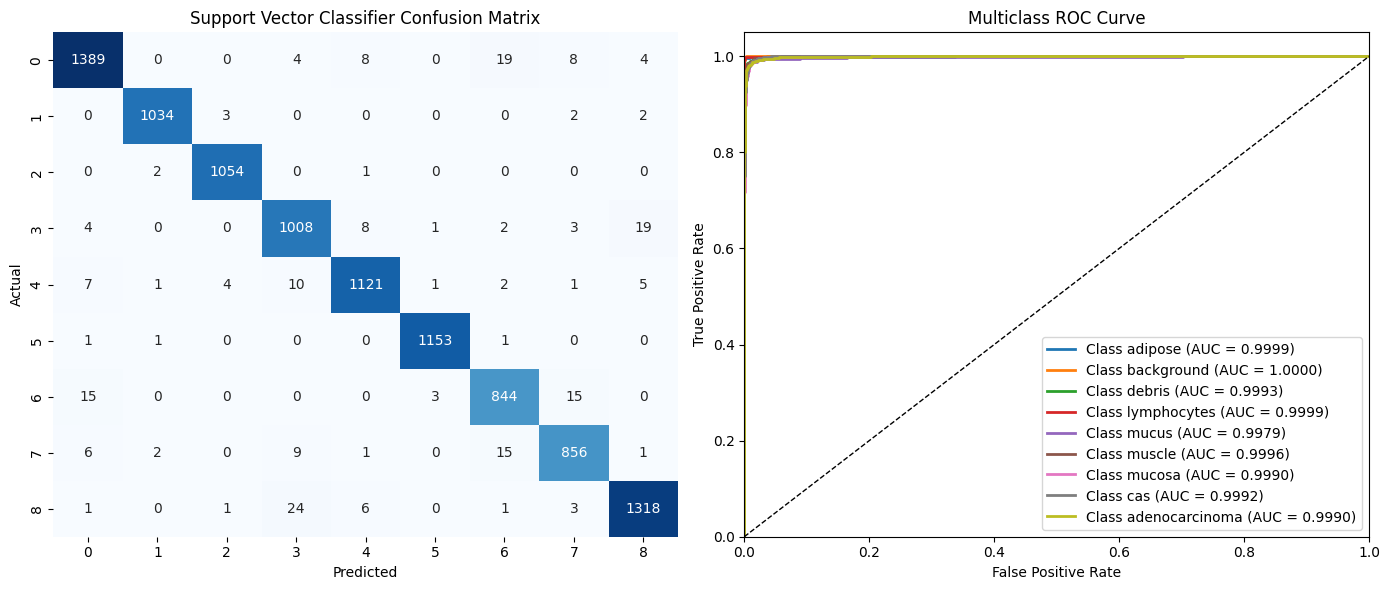

In [28]:
# confusion matrix
cm_svc = confusion_matrix(y_val_decoded, y_pred_svc_decoded)

# ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_proba_svc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#confusion matrix
sns.heatmap(cm_svc, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names, cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Support Vector Classifier Confusion Matrix")

#ROC curve for each class
for i in range(n_classes):
    axes[1].plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.4f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Multiclass ROC Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


In [29]:
with open('best_svc.pkl', 'wb') as f:
    pickle.dump(best_svc, f)

##5.4 Soft Ensemble Soft Voting Classifier

In [85]:
# Load models
# xgb
with open('best_xgb.pkl', 'rb') as xgb:
    xgb_model = pickle.load(xgb)
# knn
with open('best_knn.pkl', 'rb') as knn:
    knn_model = pickle.load(knn)

ensemble_xgbknn = VotingClassifier(
    estimators=[('xgb', xgb_model), ('knn', knn_model)],
    voting='soft'
)

ensemble_xgbknn.fit(X_train_features, y_train_encoded)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learni....125, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_class=9, num_parallel_tree=None, ...)),
                             ('knn',
                              KNeighborsClassifier(metric='manhattan', p=1,
                                                   weights='distance'))],
                 voting='soft')

In [86]:
y_pred_voting_clf = ensemble_xgbknn.predict(X_val_features)
y_proba_voting_clf = ensemble_xgbknn.predict_proba(X_val_features)

y_pred_voting_decoded = decode_fn(y_pred_voting_clf)

print(classification_report(y_val_decoded, y_pred_voting_decoded))

                precision    recall  f1-score   support

adenocarcinoma       0.96      0.96      0.96      1432
       adipose       1.00      1.00      1.00      1041
    background       1.00      1.00      1.00      1057
           cas       0.94      0.94      0.94      1045
        debris       0.98      0.96      0.97      1152
   lymphocytes       0.99      0.99      0.99      1156
        mucosa       0.91      0.94      0.92       877
         mucus       0.94      0.94      0.94       890
        muscle       0.97      0.96      0.97      1354

      accuracy                           0.97     10004
     macro avg       0.97      0.97      0.97     10004
  weighted avg       0.97      0.97      0.97     10004



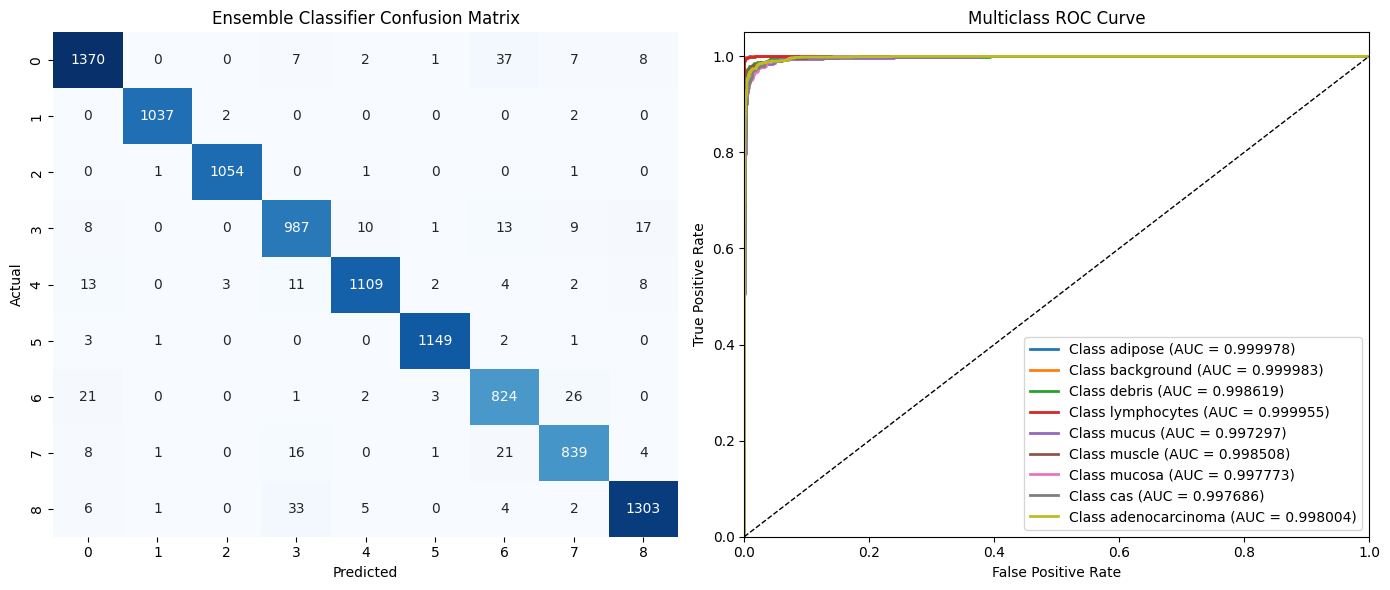

In [87]:
cm_xgb_knn = confusion_matrix(y_val_decoded, y_pred_voting_decoded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_proba_voting_clf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# confusion matrix
sns.heatmap(cm_xgb_knn, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names, cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Ensemble Classifier Confusion Matrix")

# ROC curve for each class
for i in range(n_classes):
    axes[1].plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.6f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal line for random guessing
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Multiclass ROC Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [88]:
with open('best_ensemble.pkl', 'wb') as f:
    pickle.dump(ensemble_xgbknn, f)

In [30]:
# Load models
# xgb
with open('best_xgb.pkl', 'rb') as xgb:
    xgb_model = pickle.load(xgb)
# knn
with open('best_knn.pkl', 'rb') as knn:
    knn_model = pickle.load(knn)

# svc
with open('best_svc.pkl', 'rb') as svc:
    svc_model = pickle.load(svc)

ensemble_xgbknn = VotingClassifier(
    estimators=[('svc', svc_model), ('xgb', xgb_model), ('knn', knn_model)],
    voting='soft'
)

ensemble_xgbknn.fit(X_train_features, y_train_encoded)

VotingClassifier(estimators=[('svc',
                              SVC(C=100, gamma=0.1, probability=True,
                                  random_state=5)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=...
                                            learning_rate=0.125, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_class=9, num_parallel_tree=None, ...)),
                             ('knn',
                              KNeighborsClassifier(metric='manhattan', p=1,
                                                   weights='distance'))],
                 voting='soft')

In [31]:
y_pred_voting_clf = ensemble_xgbknn.predict(X_val_features)
y_proba_voting_clf = ensemble_xgbknn.predict_proba(X_val_features)

y_pred_voting_decoded = decode_fn(y_pred_voting_clf)

print(classification_report(y_val_decoded, y_pred_voting_decoded))

                precision    recall  f1-score   support

adenocarcinoma       0.97      0.97      0.97      1432
       adipose       1.00      1.00      1.00      1041
    background       1.00      1.00      1.00      1057
           cas       0.95      0.96      0.96      1045
        debris       0.99      0.98      0.98      1152
   lymphocytes       1.00      1.00      1.00      1156
        mucosa       0.94      0.95      0.94       877
         mucus       0.96      0.96      0.96       890
        muscle       0.98      0.97      0.98      1354

      accuracy                           0.98     10004
     macro avg       0.97      0.98      0.97     10004
  weighted avg       0.98      0.98      0.98     10004



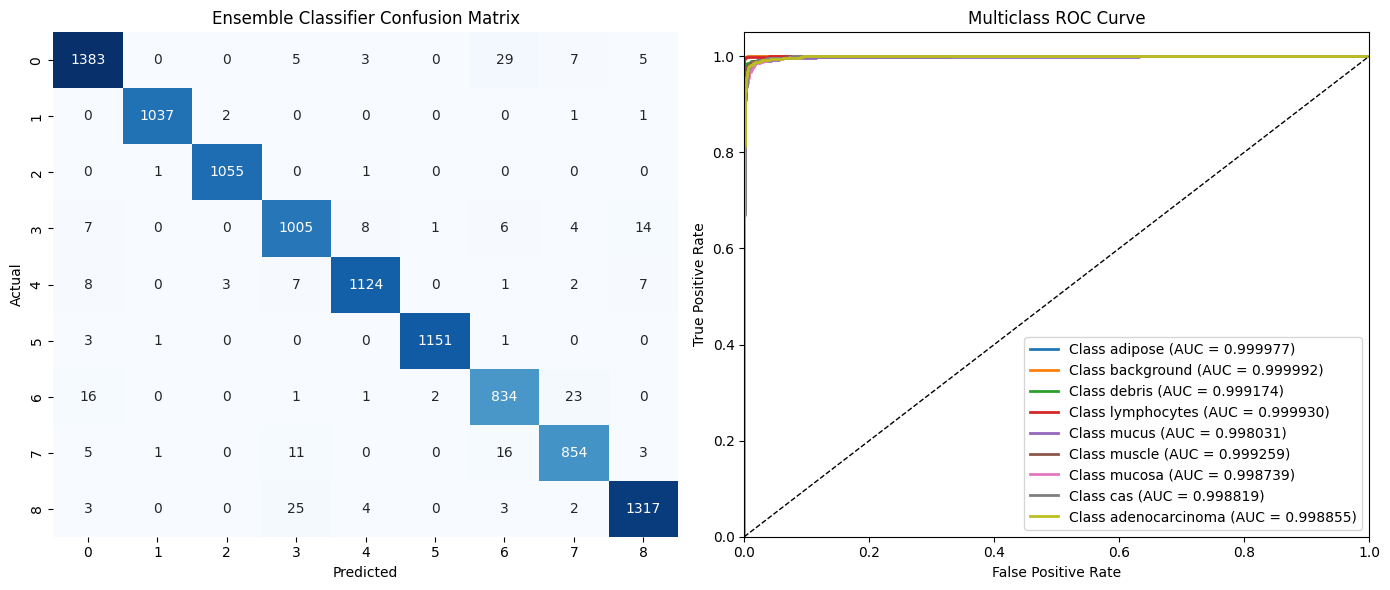

In [32]:
cm_xgb_knn = confusion_matrix(y_val_decoded, y_pred_voting_decoded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_proba_voting_clf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# confusion matrix
sns.heatmap(cm_xgb_knn, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names, cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Ensemble Classifier Confusion Matrix")

# ROC curve for each class
for i in range(n_classes):
    axes[1].plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.6f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal line for random guessing
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Multiclass ROC Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

## 5.5 Convolutional Neural Network

In [5]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [7]:
class_names = {
    0: "adipose",
    1: "background",
    2: "debris",
    3: "lymphocytes",
    4: "mucus",
    5: "muscle", # smooth muscle
    6: "mucosa", # normal colon mucosa
    7: "cas", # cancer-associated stroma
    8: "adenocarcinoma" # colorectal adenocarcinoma epithelium
}
decode_fn = np.vectorize(class_names.get)

X_train_images['class'] = X_train_images['class'].map(class_names)
X_val_images['class'] = X_val_images['class'].map(class_names)
X_test_images['class'] = X_test_images['class'].map(class_names)

In [10]:
print(X_train_images.shape)
img_gen = ImageDataGenerator(rescale=1/255)
tf.random.set_seed(42)

train_generator = img_gen.flow_from_dataframe(
    dataframe=X_train_images,
    x_col='file_path',
    y_col='class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=X_val_images,
    x_col='file_path',
    y_col='class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=X_test_images,
    x_col='file_path',
    y_col='class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

(95828, 3)
Found 95828 validated image filenames belonging to 9 classes.
Found 10004 validated image filenames belonging to 9 classes.
Found 7180 validated image filenames belonging to 9 classes.


In [14]:
# to verify the generators are working
print("Training generator info:")
print("Number of batches:", len(train_generator))
print("Number of classes:", len(train_generator.class_indices))
print("Class indices:", train_generator.class_indices)

# verify that the data is loading correctly
print("\nTrying to load one batch:")
try:
    batch_x, batch_y = next(train_generator)
    print("Batch shapes:")
    print("Input shape:", batch_x.shape)
    print("Output shape:", batch_y.shape)
except Exception as e:
    print("Error loading batch:", str(e))

# verify validation generator
print("\nValidation generator info:")
print("Number of samples:", len(val_generator))
print("Number of classes:", len(val_generator.class_indices))

# check the paths
print("\nChecking first few file paths:")
for i, row in X_train_images.head().iterrows():
    print("File exists:", os.path.exists(row['file_path']))

Training generator info:
Number of batches: 2995
Number of classes: 9
Class indices: {'adenocarcinoma': 0, 'adipose': 1, 'background': 2, 'cas': 3, 'debris': 4, 'lymphocytes': 5, 'mucosa': 6, 'mucus': 7, 'muscle': 8}

Trying to load one batch:
Batch shapes:
Input shape: (32, 128, 128, 3)
Output shape: (32, 9)

Validation generator info:
Number of samples: 313
Number of classes: 9

Checking first few file paths:
File exists: True
File exists: True
File exists: True
File exists: True
File exists: True


In [10]:
#tf.keras.backend.clear_session()
cnn = Sequential()

cnn.add(Conv2D(32, (7, 7), activation='relu', padding='same', name='conv_1.1',
                 input_shape=(128, 128, 3)))
cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1.2'))
cnn.add(MaxPooling2D((2, 2), name='maxpool_1'))

cnn.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_2.1'))
cnn.add(Conv2D(128, (3, 3), padding='same', name='conv_2.2'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D((2, 2), name='maxpool_2'))
cnn.add(Dropout(0.1))

cnn.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='conv_3.1'))
cnn.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='conv_3.2'))
cnn.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='conv_3.4'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D((2, 2), name='maxpool_3'))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.002), name='conv_4.1'))
cnn.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.002), name='conv_4.2'))
cnn.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.002), name='conv_4.3'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D((2, 2), name='maxpool_4'))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.005), name='conv_5.1'))
cnn.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.005), name='conv_5.2'))
cnn.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.005), name='conv_5.3'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D((2, 2), name='maxpool_5'))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.005), name='conv_6.1'))
cnn.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.005), name='conv_6.2'))
cnn.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.005), name='conv_6.3'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D((2, 2), name='maxpool_6'))


# Fully connected
cnn.add(GlobalAveragePooling2D(name='gap'))
cnn.add(Dropout(0.5, name='dropout_gap'))
cnn.add(Dense(256,
              activation='relu',
              kernel_regularizer=l2(1e-3),
              name='dense_1'))
cnn.add(Dropout(0.5, name='dropout_dense'))
cnn.add(Dense(64,
              activation='relu',
              kernel_regularizer=l2(1e-3),
              name='dense_2'))
cnn.add(Dense(9, activation='softmax', name='output'))

opt = Adam(learning_rate=1e-3)
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), F1Score(name='f1_score', average='macro')])

cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1.1 (Conv2D)               │ (None, 128, 128, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1.2 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2.1 (Conv2D)               │ (None, 64, 64, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2.2 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3.1 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3.2 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3.4 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4.1 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4.2 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4.3 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_4 (MaxPooling2D)        │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,888,553 (83.50 MB)

 Trainable params: 21,884,713 (83.48 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [11]:
tf.debugging.set_log_device_placement(True)
early_stopping = EarlyStopping(
    monitor='val_f1_score',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'custom_cnn_best_model.keras',
    monitor='val_f1_score',
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)

history = cnn.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[reduce_lr, checkpoint, early_stopping],
    verbose=1)

cnn.save('custom_cnn_final_model.h5')
cnn.save('best_cnn.keras')

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2995/2995 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.3128 - f1_score: 0.2806 - loss: 4.1814 - precision: 0.6954 - recall: 0.1381

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2995/2995 ━━━━━━━━━━━━━━━━━━━━ 618s 194ms/step - accuracy: 0.3129 - f1_score: 0.2806 - loss: 4.1808 - precision: 0.6954 - recall: 0.1381 - val_accuracy: 0.1075 - val_f1_score: 0.0540 - val_loss: 4.7320 - val_precision: 0.1311 - val_recall: 0.1067 - learning_rate: 0.0010
Epoch 2/50
2995/2995 ━━━━━━━━━━━━━━━━━━━━ 541s 180ms/step - accuracy: 0.4494 - f1_score: 0.3952 - loss: 1.4718 - precision: 0.7505 - recall: 0.2241 - val_accuracy: 0.4817 - val_f1_score: 0.4080 - val_loss: 1.4321 - val_precision: 0.7490 - val_recall: 0.2756 - learning_rate: 0.0010
Epoch 3/50
2995/2995 ━━━━━━━━━━━━━━━━━━━━ 523s 175ms/step - accuracy: 0.5508 - f1_score: 0.5269 - loss: 1.2491 - precision: 0.7313 - recall: 0.3495 - val_accuracy: 0.3515 - val_f1_score: 0.2833 - val_loss: 1.9649 - val_precision: 0.4802 - val_recall: 0.2819 - learning_rate: 0.0010
Epoch 4/50
2995/2995 ━━━━━━━━━━━━━━━━━━━━ 529s 177ms/step - accuracy: 0.6538 - f1_score: 0.6478 - loss: 1.0427 - precision: 0.7512 - recall: 0.5119 - val_accuracy: 0

In [12]:
history_dict = history.history
print("Keys available in history:", history_dict.keys())

Keys available in history: dict_keys(['accuracy', 'f1_score', 'loss', 'precision', 'recall', 'val_accuracy', 'val_f1_score', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])


(0.0, 2.0)

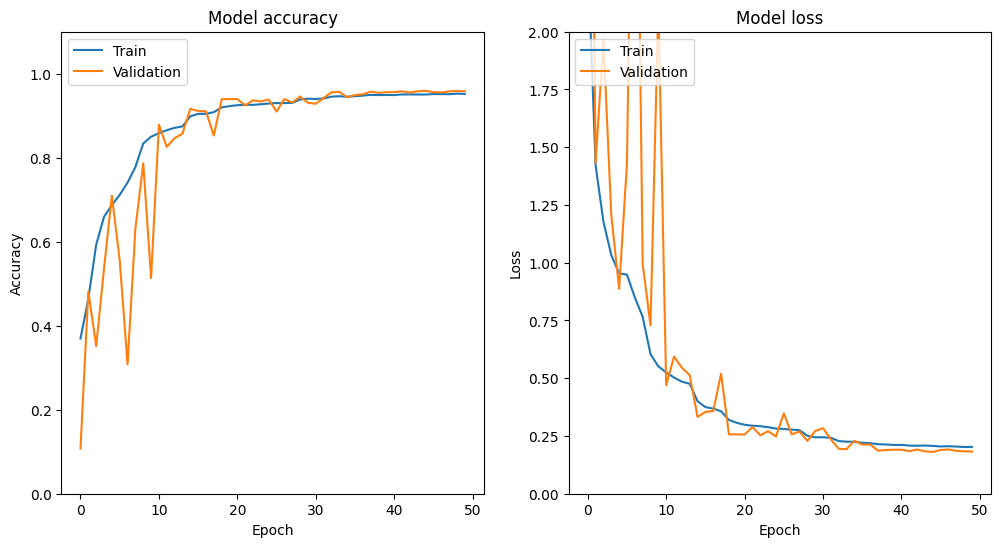

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim((0,1.1))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim((0,2))

In [16]:
# Upload the dataset to the drive
import tarfile
with tarfile.open('/content/class_task.tar.gz', 'w:gz') as tar:
    tar.add('/content/class_task', arcname='class_task')

!mv /content/class_task.tar.gz /content/drive/MyDrive/aml_project/class_task_new.tar.gz

# 6. Comparative Benchmarking

In [15]:
import pickle

# xgb
with open('best_xgb.pkl', 'rb') as xgb:
    xgb_model = pickle.load(xgb)

# knn
with open('best_knn.pkl', 'rb') as knn:
    knn_model = pickle.load(knn)

# ensemble
with open('best_ensemble.pkl', 'rb') as voting_ensemble:
    voting_ensemble = pickle.load(voting_ensemble)

# cnn
cnn_model = tf.keras.models.load_model('best_cnn.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 50 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [25]:
xgb_model.fit(X_train_features, y_train_encoded)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:17:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.125, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_class=9, num_parallel_tree=None, ...)

In [26]:
knn_model.fit(X_train_features, y_train_encoded)

KNeighborsClassifier(metric='manhattan', p=1, weights='distance')

In [27]:
voting_ensemble = VotingClassifier(
    estimators=[('xgb', xgb_model), ('knn', knn_model)],
    voting='soft'
)

voting_ensemble.fit(X_train_features, y_train_encoded)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:20:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learni....125, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_class=9, num_parallel_tree=None, ...)),
                             ('knn',
                              KNeighborsClassifier(metric='manhattan', p=1,
                                                   weights='distance'))],
                 voting='soft')

In [16]:
# get probabilities for each model
y_proba_xgb = xgb_model.predict_proba(X_test_features)

y_proba_knn = knn_model.predict_proba(X_test_features)

y_proba_ensemble = voting_ensemble.predict_proba(X_test_features)

y_proba_cnn = cnn_model.predict(test_generator)

# get the models' predictions

y_pred_xgb = xgb_model.predict(X_test_features)

y_pred_knn = knn_model.predict(X_test_features)

y_pred_ensemble = voting_ensemble.predict(X_test_features)

y_pred_cnn = np.argmax(y_proba_cnn, axis=1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [17]:
cnn_mapping = test_generator.class_indices
true_label_mapping = {
    "adipose": 0,
    "background": 1,
    "debris": 2,
    "lymphocytes": 3,
    "mucus": 4,
    "muscle": 5,
    "mucosa": 6,
    "cas": 7,
    "adenocarcinoma": 8
}
cnn_index_to_true_index = {cnn_mapping[class_name]: true_label_mapping[class_name]
                           for class_name in cnn_mapping}

y_pred_cnn_true = np.vectorize(cnn_index_to_true_index.get)(y_pred_cnn)

y_proba_cnn_true = y_proba_cnn[:, [k for k, _ in sorted(cnn_index_to_true_index.items(), key=lambda x: x[1])]]

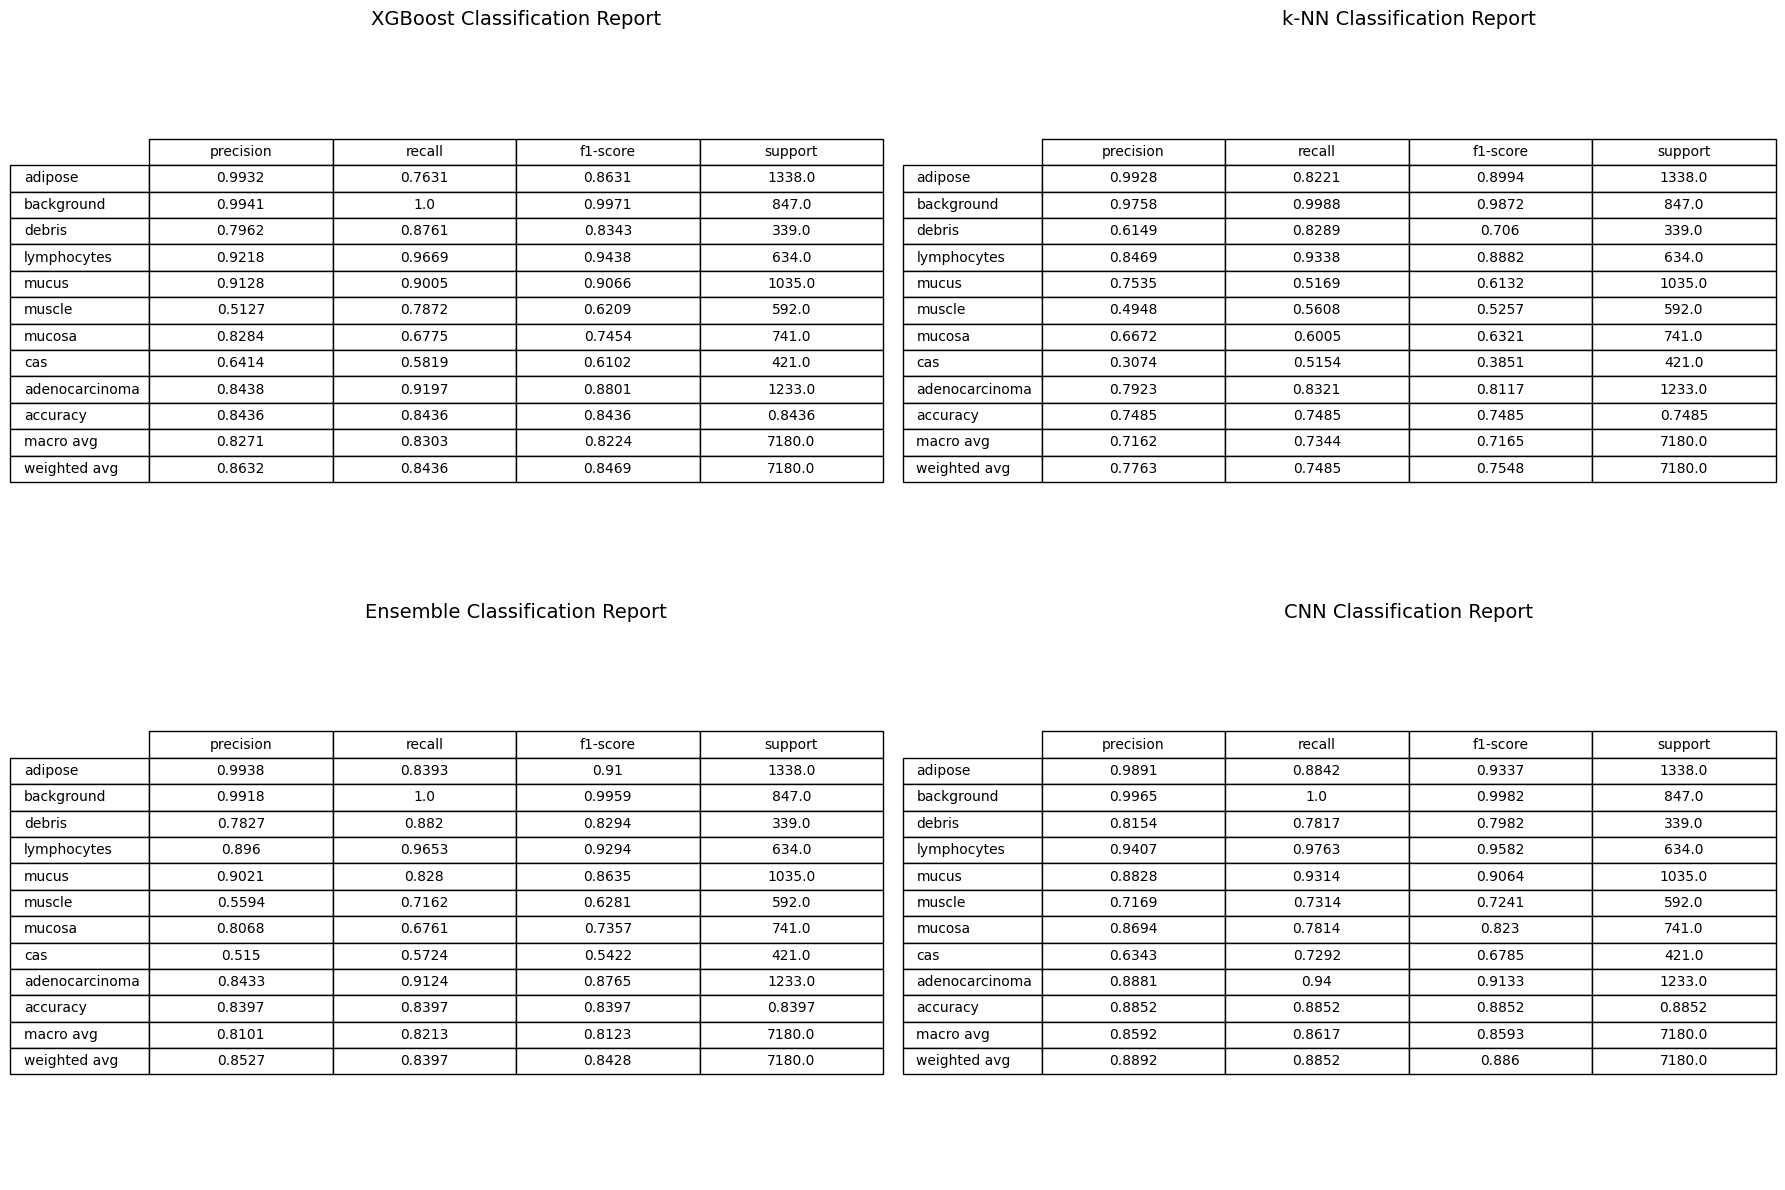

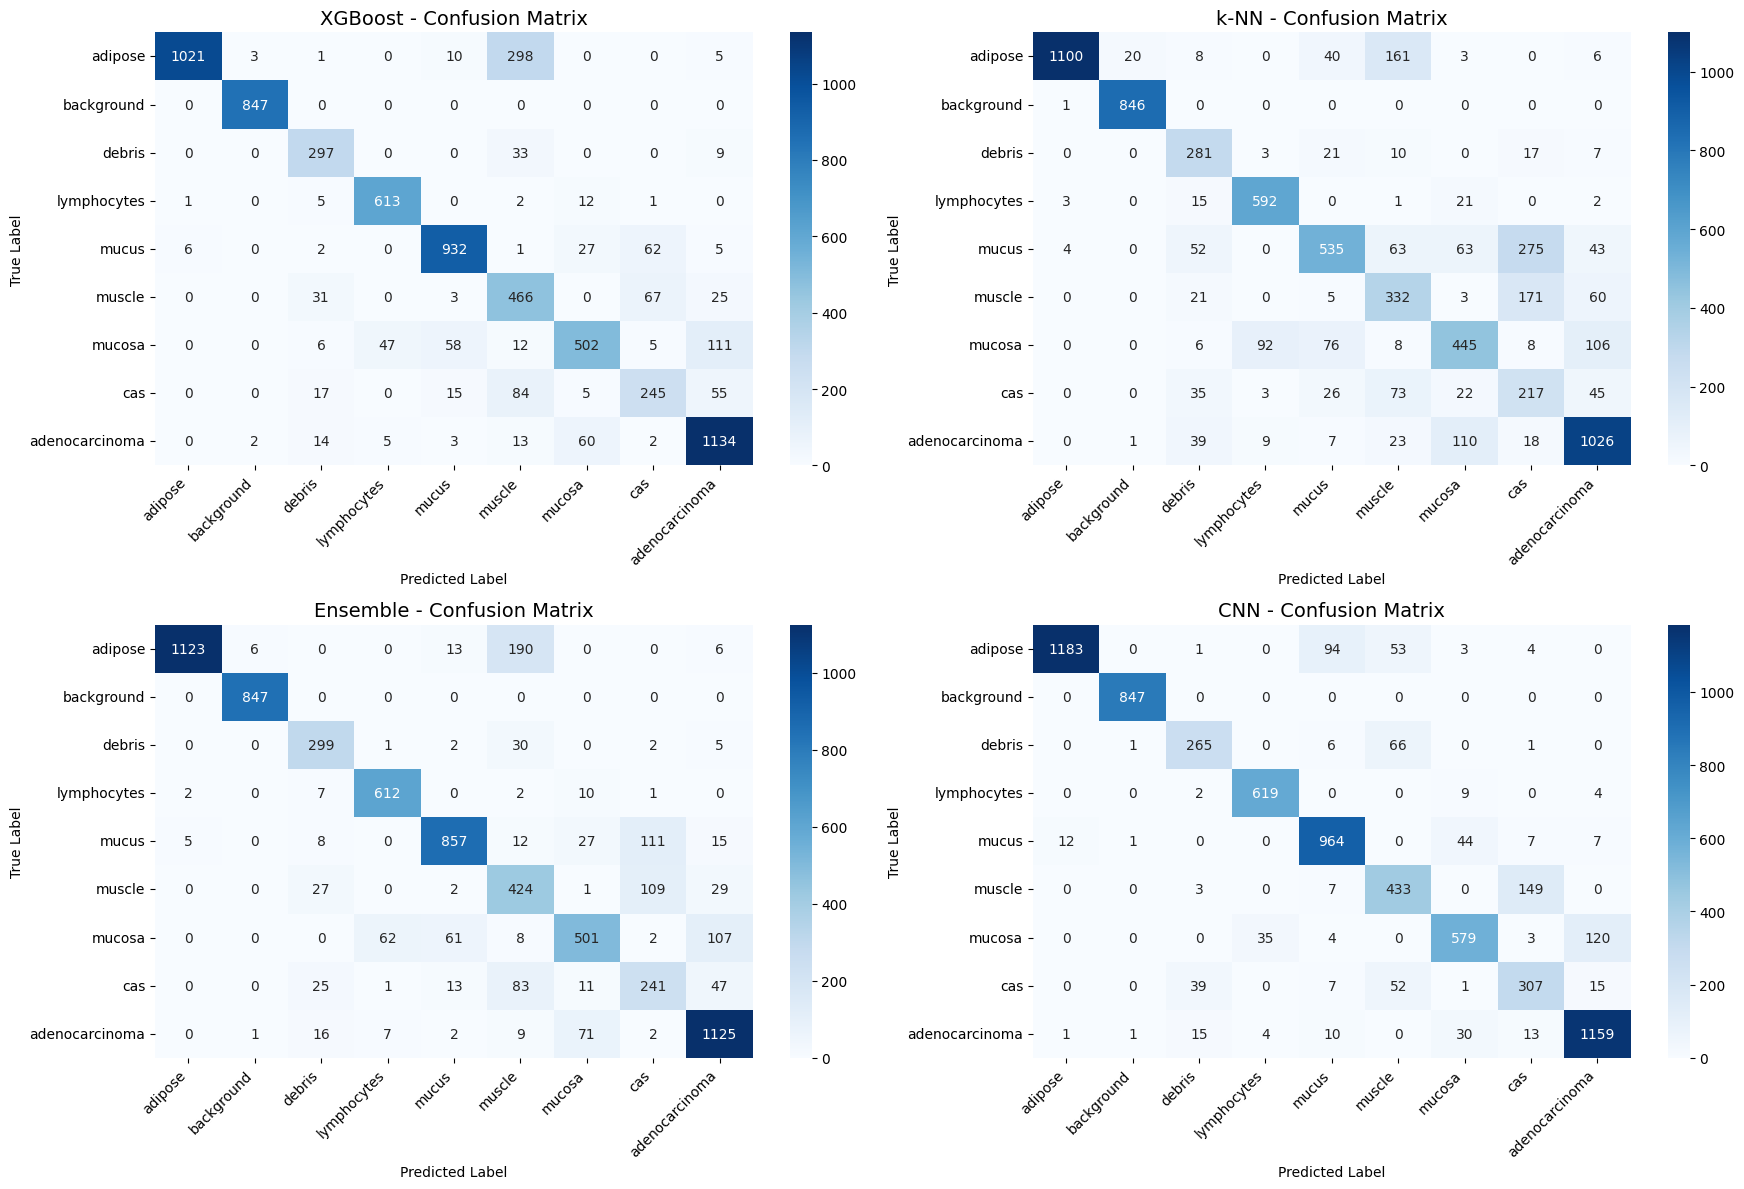

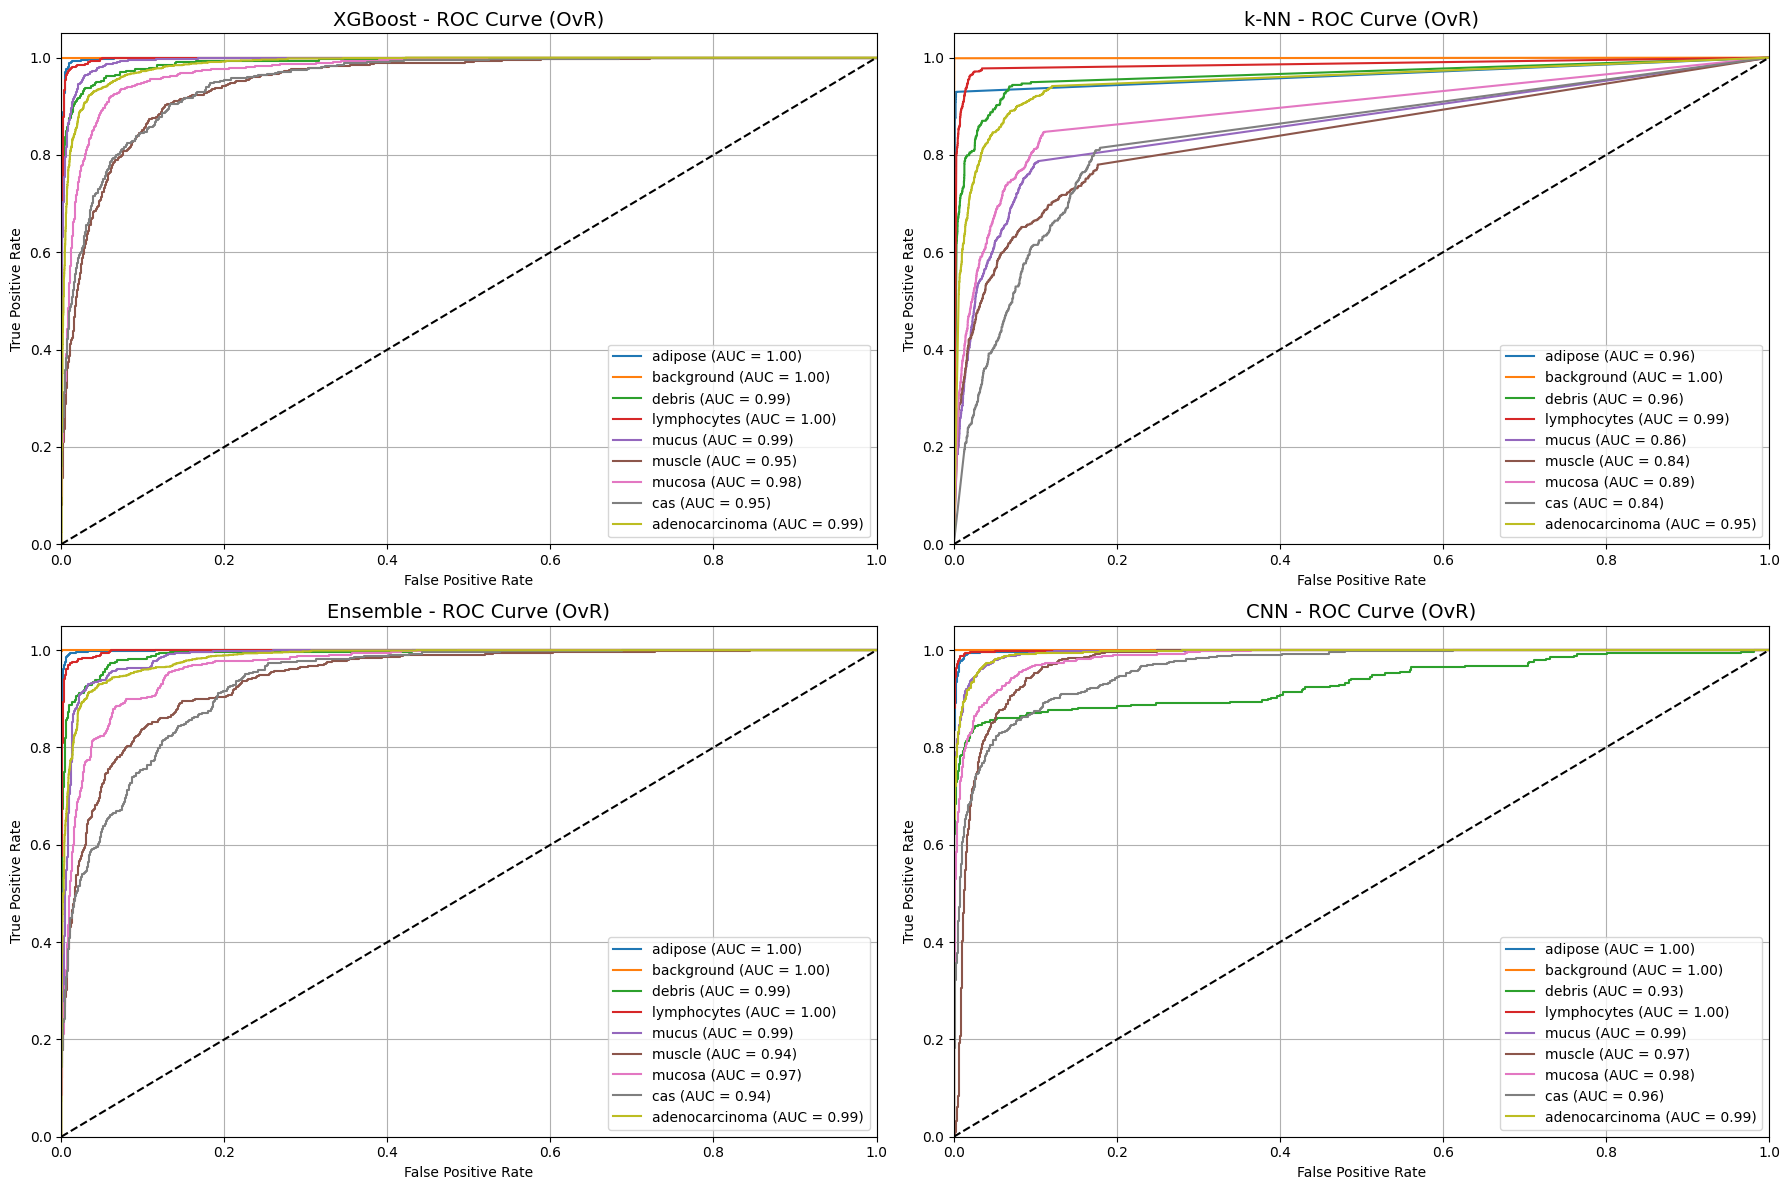

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

n_classes = len(class_names)
class_labels = list(class_names.values())

y_test_bin = label_binarize(y_test_encoded, classes=list(range(n_classes)))

model_results = {
    "XGBoost": (y_pred_xgb, y_proba_xgb),
    "k-NN": (y_pred_knn, y_proba_knn),
    "Ensemble": (y_pred_ensemble, y_proba_ensemble),
    "CNN": (y_pred_cnn_true, y_proba_cnn_true)
}

model_names = list(model_results.keys())
true_labels = [y_test_encoded] * 4
pred_labels = [model_results[m][0] for m in model_names]

# Classification Reports
plt.figure(figsize=(18, 12))
for i, (true, pred) in enumerate(zip(true_labels, pred_labels)):
    plt.subplot(2, 2, i + 1)
    report = classification_report(true, pred, target_names=class_labels,
                                   output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose().round(4)

    table = plt.table(cellText=report_df.values,
                      colLabels=report_df.columns,
                      rowLabels=report_df.index,
                      cellLoc="center",
                      loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.axis("off")
    plt.title(f'{model_names[i]} Classification Report', fontsize=14)

plt.tight_layout()
plt.show()

# Confusion Matrices
plt.figure(figsize=(18, 12))
for i, (model_name, (y_pred, _)) in enumerate(model_results.items()):
    cm = confusion_matrix(y_test_encoded, y_pred)
    plt.subplot(2, 2, i + 1)
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=class_labels,
                yticklabels=class_labels,
                cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix", fontsize=14)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# ROC Curves
plt.figure(figsize=(18, 12))
for i, (model_name, (_, y_proba)) in enumerate(model_results.items()):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_proba[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    plt.subplot(2, 2, i + 1)
    for j in range(n_classes):
        plt.plot(fpr[j], tpr[j], label=f"{class_names[j]} (AUC = {roc_auc[j]:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve (OvR)", fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True)

plt.tight_layout()
plt.show()
